Rusty Bargain adalah perusahaan jual beli mobil bekas yang sedang mengembangkan sebuah aplikasi untuk menarik pembeli baru. Dalam aplikasi tersebut, kamu bisa dengan cepat mengetahui nilai pasar mobilmu. Kamu memiliki akses ke data historis, spesifikasi teknis kendaraan, versi model kendaraan, dan harga kendaraan.

Fitur
- DateCrawled — tanggal ketika profil diunduh dari database
- VehicleType — jenis bodi kendaraan
- RegistrationYear — tahun registrasi kendaraan
- Gearbox — jenis transmisi
- Power — daya (hp)
- Model — model kendaraan
- Mileage — jarak tempuh (diukur dalam satuan km berdasarkan dataset regional tertentu)
- RegistrationMonth — bulan registrasi kendaraan
- FuelType — jenis bahan bakar
- Brand — merek kendaraan
- NotRepaired — apakah kendaraan pernah direparasi sebelumnya
- DateCreated — tanggal pembuatan profil
- NumberOfPictures — jumlah gambar kendaraan
- PostalCode — kode pos pemilik profil (pengguna)
- LastSeen — tanggal aktivitas terakhir pengguna

Target
- Price — harga (dalam satuan Euro)

## Persiapan Data

Data yang akan digunakan disiapkan terlebih dahulu. Tahapan persiapan data meliputi penyiapan library, observasi data awal, eksplorasi data, serta pra-pengolahan data. 

### Pemuatan Library dan Observasi Awal Data

In [1]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

In [2]:
df_ori = pd.read_csv('/datasets/car_data.csv')

In [3]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df_ori.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
89756,26/03/2016 08:36,1,sedan,2003,auto,170,NaN,150000,5,petrol,audi,no,26/03/2016 00:00,0,26386,03/04/2016 19:47
286806,05/03/2016 17:57,900,sedan,1999,auto,101,astra,150000,7,petrol,opel,no,05/03/2016 00:00,0,6308,05/03/2016 20:46
184510,15/03/2016 17:49,600,small,1999,manual,0,clio,150000,5,petrol,renault,NaN,15/03/2016 00:00,0,90480,22/03/2016 21:47
171658,21/03/2016 11:06,1650,sedan,1996,manual,75,astra,80000,7,petrol,opel,no,21/03/2016 00:00,0,65594,06/04/2016 06:46
129476,01/04/2016 11:36,899,small,2000,manual,0,corsa,150000,0,NaN,opel,no,01/04/2016 00:00,0,47443,01/04/2016 12:43


In [5]:
df_ori.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Observasi awal data menunjukkan banyak kolom yang tidak diperlukan dan beberapa kolom kategorik memiliki nilai yang hilang. 

### Pra-Pengolahan Data

#### Penghilangan Data yang tidak terpakai

Pada tahapan ini kolom yang tidak terpakai atau yang tidak memengaruhi nilai harga secara logis dihilangkan terlebih dahulu. 

In [6]:
df = df_ori.copy()

In [7]:
df.drop(['DateCrawled', 'LastSeen', 'DateCreated', 'RegistrationMonth', 'PostalCode', 'NumberOfPictures'], axis = 1, inplace= True)

In [8]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Mileage', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

#### Pengisian Nilai yang Hilang

Selanjutnya nilai yang hilang di nilai kategorik diisi menggunakan kata 'unknown' menjadi kategori sendiri

In [9]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired' ]
numerical = ['Price', 'Power','Mileage']

In [10]:
for col in categorical:
    df[col].fillna('unknown', inplace=True)

In [11]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Mileage             0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

#### Eksplorasi Korelasi Data

Tidak terdapat nilai yang hilang di kolo numerikal. Pertama dilihat korelasi kolom-kolom kategorikal dan numerikal terhadap harga. Pertama nilai kategorik harus dienkripsi menjadi data numerik menggunakan One-Hot Encoding. Selanjutnya untuk kolom numerik dilihat apakah ada nilai outlier

In [12]:
for feature in categorical:
    print(f'features {feature} {len(df[feature].value_counts())}')

features VehicleType 9
features Gearbox 3
features Model 251
features FuelType 8
features NotRepaired 3


In [13]:
df_type = pd.get_dummies(df[['VehicleType', 'Price']], drop_first= True)

In [14]:
df_type.head()

,Price,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon
0,480,0,0,0,0,0,0,1,0
1,18300,0,1,0,0,0,0,0,0
2,9800,0,0,0,0,0,1,0,0
3,1500,0,0,0,0,1,0,0,0
4,3600,0,0,0,0,1,0,0,0


In [15]:
df_type.shape

(354369, 9)

In [16]:
df_type.corr()['Price']

Price                      1.000000
VehicleType_convertible    0.130201
VehicleType_coupe          0.077205
VehicleType_other         -0.018283
VehicleType_sedan          0.039981
VehicleType_small         -0.207735
VehicleType_suv            0.190435
VehicleType_unknown       -0.155534
VehicleType_wagon          0.048760
Name: Price, dtype: float64

In [17]:
df_brand = pd.get_dummies(df[['Brand', 'Price']], drop_first= True)

In [18]:
df_brand.shape

(354369, 40)

In [19]:
df_brand.corr()['Price']

Price                   1.000000
Brand_audi              0.121616
Brand_bmw               0.131860
Brand_chevrolet         0.019103
Brand_chrysler         -0.009984
Brand_citroen          -0.025537
Brand_dacia             0.015906
Brand_daewoo           -0.029469
Brand_daihatsu         -0.028801
Brand_fiat             -0.063790
Brand_ford             -0.076027
Brand_honda            -0.015213
Brand_hyundai           0.015487
Brand_jaguar            0.018987
Brand_jeep              0.025668
Brand_kia               0.010477
Brand_lada             -0.007701
Brand_lancia           -0.016693
Brand_land_rover        0.034887
Brand_mazda            -0.022368
Brand_mercedes_benz     0.104345
Brand_mini              0.096797
Brand_mitsubishi       -0.030498
Brand_nissan           -0.008744
Brand_opel             -0.133088
Brand_peugeot          -0.051728
Brand_porsche           0.067467
Brand_renault          -0.109789
Brand_rover            -0.025450
Brand_saab             -0.006393
Brand_seat

In [20]:
df.groupby('Gearbox')['Price'].mean()

Gearbox
auto       6842.065007
manual     3980.757507
unknown    2206.311904
Name: Price, dtype: float64

In [21]:
df.corr()

,Price,RegistrationYear,Power,Mileage
Price,1.000000,0.026916,0.158872,-0.333199
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447
Power,0.158872,-0.000828,1.000000,0.024002
Mileage,-0.333199,-0.053447,0.024002,1.000000


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


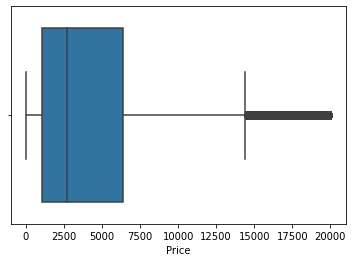

In [22]:
sns.boxplot(df['Price'])
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


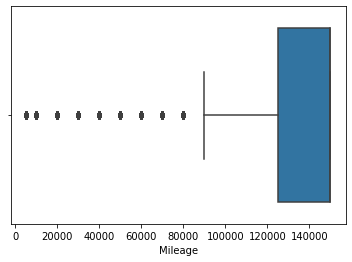

In [23]:
sns.boxplot(df['Mileage'])
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


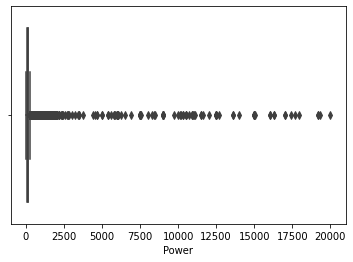

In [24]:
sns.boxplot(df['Power'])
plt.show()

In [25]:
df.corr()

,Price,RegistrationYear,Power,Mileage
Price,1.000000,0.026916,0.158872,-0.333199
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447
Power,0.158872,-0.000828,1.000000,0.024002
Mileage,-0.333199,-0.053447,0.024002,1.000000


In [26]:
df[numerical].describe()

,Price,Power,Mileage
count,354369.000000,354369.000000,354369.000000
mean,4416.656776,110.094337,128211.172535
std,4514.158514,189.850405,37905.341530
min,0.000000,0.000000,5000.000000
25%,1050.000000,69.000000,125000.000000
50%,2700.000000,105.000000,150000.000000
75%,6400.000000,143.000000,150000.000000
max,20000.000000,20000.000000,150000.000000


Terdapat nilai outlier pada kolom numerikal. Data-data outlier perlu difilter terlebih dahulu. 

#### Penghilangan Outlier Data

In [27]:
def remove_outlier(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    data = data.loc[(data[col]>= Q1-1.5*IQR)&(data[col]<= Q3+1.5*IQR)]
    return data

In [28]:
df_mil = remove_outlier(df, 'Mileage')
df_pow = remove_outlier(df_mil, 'Power')
df_main = remove_outlier(df_pow, 'Price')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


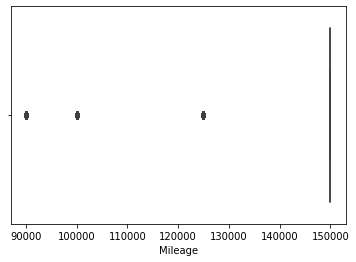

In [29]:
sns.boxplot(df_main['Mileage'])
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


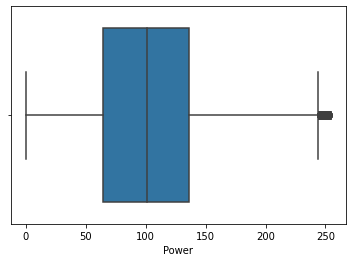

In [30]:
sns.boxplot(df_main['Power'])
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


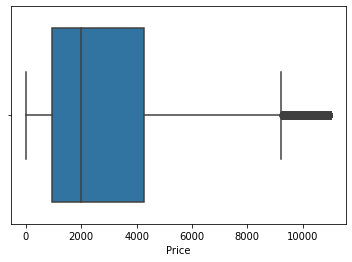

In [31]:
sns.boxplot(df_main['Price'])
plt.show()

In [32]:
df_main[numerical].describe()

,Price,Power,Mileage
count,275481.000000,275481.000000,275481.000000
mean,2943.156396,99.486792,142924.775211
std,2628.280714,54.862362,15870.327237
min,0.000000,0.000000,90000.000000
25%,950.000000,64.000000,150000.000000
50%,2000.000000,101.000000,150000.000000
75%,4250.000000,136.000000,150000.000000
max,10999.000000,254.000000,150000.000000


Setelah dilakukan outlier, ternyata muncul kembali outlier yang disebabkan oleh perubahan rentang data yang baru. Akan tetapi outlier ini akan dibiarkan karena outlier dari data sebelum pemfilteran sudah dihilangkan. 

#### Enkripsi Data

In [33]:
df_encode = pd.get_dummies(df_main, drop_first= True)

In [34]:
df_encode.shape

(275481, 308)

Enkripsi data dilakukan untuk mempersiapkan data yang akan digunakan dalam pelatihan model regresi.

## Pelatihan Model

Pelatihan model akan dilakukan dalam tiga seksi. Pada tahapan pertama, akan dilakukan pelatihan model sederhana Decision Tree Regressor. Tahapan kedua merupakan pelatihan model dengan kompleksitas medium yaitu Random Forest Regressor. Pada tahapan terakhir akan dilakukan boosting gradien dengan tiga algoritma yaitu LightGBM, CatBoost, dan XGB. Model regresi Linear akan digunakan sebagai baseline keberhasilan boosting model yang akan digunakan. 

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [36]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [37]:
def eval_regressor(y_true, y_pred):
    print(f'Skor R2 model: {r2_score(y_true, y_pred)}, RMSE model : {mean_squared_error(y_true, y_pred)**0.5}, dan MAE model: {mean_absolute_error(y_true, y_pred)}')

In [38]:
price_mean = pd.Series([df_main['Price'].mean()]*(df_main.shape[0]))

In [39]:
eval_regressor(df_main['Price'], price_mean)

Skor R2 model: 0.0, RMSE model : 2628.275943832722, dan MAE model: 2102.5935831072397


Program evaluasi regresi diuji terlebih dahulu menggunakan prediksi mean data harga dan target harga. Terlihat bahwa prediksi menggunakan mean memiliki nilai R2 yang kecil, derta error yang besar, sehingga prediksi target dengan mean tidak baik.

### Pelatihan model sederhana

Pada tahapan ini, data utama akan dipecah menjadi tiga data, yaitu data training, data validasi dan data testing dengan rasion 60: 20: 20. 

In [40]:
X= df_encode.drop('Price', axis= 1)

In [41]:
y = df_encode['Price']

In [42]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.4, random_state= 12345)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state= 12345)

In [43]:
for depth in range(10, 20):
    best_rmse = []
    model = DecisionTreeRegressor(max_depth = depth, random_state = 12345)
    model.fit(X_train, y_train)
    predict_valid = model.predict(X_valid)
    predict_test = model.predict(X_test)
    print(depth)
    print(eval_regressor(y_valid, predict_valid))
    print(eval_regressor(y_test, predict_test))

10
Skor R2 model: 0.6981293336357512, RMSE model : 1443.3799939605778, dan MAE model: 988.0393222114997
None
Skor R2 model: 0.6999205215687804, RMSE model : 1435.7637962229533, dan MAE model: 980.2035995896977
None
11
Skor R2 model: 0.7074834294698473, RMSE model : 1420.840936517404, dan MAE model: 963.9541521989487
None
Skor R2 model: 0.7092865355027056, RMSE model : 1413.179807556089, dan MAE model: 957.0066241579115
None
12
Skor R2 model: 0.7147730461118937, RMSE model : 1403.0253134272984, dan MAE model: 942.5430026936235
None
Skor R2 model: 0.7147553425234913, RMSE model : 1399.8245615633684, dan MAE model: 937.9790615673026
None
13
Skor R2 model: 0.7195546352625399, RMSE model : 1391.2153405595368, dan MAE model: 924.9226997340148
None
Skor R2 model: 0.7201000785462839, RMSE model : 1386.6480276268012, dan MAE model: 920.5654076135072
None
14
Skor R2 model: 0.7235035062007578, RMSE model : 1381.3859641590457, dan MAE model: 909.3508053773837
None
Skor R2 model: 0.7242414635225681

Penyesuaian hiperparameter untuk model decision tree regressor menunjukan kedalaman maksimum pohon 16 sebagai parameter terbaik.

### Pelatihan model medium

In [44]:
best_rmse = float('inf')
for est in range(10, 20):
    for depth in range (2, 10):
        model = RandomForestRegressor(n_estimators = est, max_depth = depth, random_state= 12345)
        model.fit(X_train, y_train)
        predict_valid = model.predict(X_valid)
        rmse = mean_squared_error(y_valid, predict_valid)**0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_depth = depth
            best_est = est
print(f'The best RMSE is {best_rmse} at estimators {best_est} and depth {best_depth}')

The best RMSE is 1420.8641100350185 at estimators 19 and depth 9


Penyesuaian hiperparameter model random forest regressor menunjukkan nilain parameter terbaik adalah 19 untuk jumlah estimator dan 9 untuk kedalaman maksimum pohon. 

### Pelatihan Gradient Boosting

Pada tahapan ini, akan dilakukan penyesuaian parameter metode model dengan gradient boosting. Akan dicoba tiga model yaitu LightGBM, CatBoost, dan XGBM. 

In [45]:
# Pelatihan dengan Gradient Boosting LightBGM
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label= y_train)
valid_data = lgb.Dataset(X_valid, label= y_valid, reference= train_data)

In [46]:
param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1]}

In [47]:
lgb_regressor = lgb.LGBMRegressor(boosting_type= 'gbdt', objective= 'regression', metric= 'rmse')
lgb_search = GridSearchCV(estimator=lgb_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
lgb_search.fit(X_train, y_train)
lgb_params = lgb_search.best_params_
print("Best Hyperparameters:", lgb_params)

Best Hyperparameters: {'learning_rate': 0.1, 'num_leaves': 40}


Penyesuaian hiperparameter terbaik untk LightBGM menunjukan nilai learning_rate 0.1 dan num_leaves 40

In [48]:
lgb_param = {'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_iterations': 100,
    'num_leaves': 40,
    'learning_rate': 0.1}
best_lgb = lgb.LGBMRegressor(**lgb_param)

In [49]:
# Gradient boosting dengan CatBoost
from catboost import CatBoostRegressor
param_grid = {
    'iterations': [100, 150, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [3, 5, 7],
}

In [ ]:
cb_regressor = CatBoostRegressor()
cb_search = GridSearchCV(estimator=cb_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
cb_search.fit(X_train, y_train)
best_cb_param = cb_search.best_params_
print(best_cb_param)

0:	learn: 2618.5252778	total: 20.1ms	remaining: 1.99s
1:	learn: 2605.1917566	total: 39.9ms	remaining: 1.95s
2:	learn: 2591.9704820	total: 60.4ms	remaining: 1.95s
3:	learn: 2578.9412702	total: 78.1ms	remaining: 1.87s
4:	learn: 2566.1220597	total: 95.2ms	remaining: 1.81s
5:	learn: 2553.4565130	total: 113ms	remaining: 1.76s
6:	learn: 2541.1427322	total: 129ms	remaining: 1.72s
7:	learn: 2528.7931140	total: 146ms	remaining: 1.68s
8:	learn: 2516.6405076	total: 163ms	remaining: 1.65s
9:	learn: 2504.7778534	total: 181ms	remaining: 1.63s
10:	learn: 2493.1483356	total: 198ms	remaining: 1.6s
11:	learn: 2481.8717601	total: 217ms	remaining: 1.59s
12:	learn: 2470.4532172	total: 236ms	remaining: 1.58s
13:	learn: 2458.7684538	total: 252ms	remaining: 1.55s
14:	learn: 2447.5750486	total: 270ms	remaining: 1.53s
15:	learn: 2436.4551294	total: 287ms	remaining: 1.51s
16:	learn: 2425.2588607	total: 307ms	remaining: 1.5s
17:	learn: 2414.1507551	total: 325ms	remaining: 1.48s
18:	learn: 2403.6481930	total: 344m

58:	learn: 2075.1237116	total: 1.05s	remaining: 730ms
59:	learn: 2068.7881374	total: 1.07s	remaining: 713ms
60:	learn: 2062.6976271	total: 1.08s	remaining: 694ms
61:	learn: 2056.5821226	total: 1.1s	remaining: 675ms
62:	learn: 2050.4811623	total: 1.12s	remaining: 658ms
63:	learn: 2044.5953555	total: 1.14s	remaining: 640ms
64:	learn: 2038.7733834	total: 1.15s	remaining: 621ms
65:	learn: 2033.2859316	total: 1.17s	remaining: 603ms
66:	learn: 2027.7903507	total: 1.19s	remaining: 585ms
67:	learn: 2022.3429216	total: 1.2s	remaining: 567ms
68:	learn: 2016.6816896	total: 1.22s	remaining: 550ms
69:	learn: 2011.1953605	total: 1.24s	remaining: 532ms
70:	learn: 2005.8093157	total: 1.26s	remaining: 514ms
71:	learn: 2000.3798796	total: 1.28s	remaining: 496ms
72:	learn: 1995.0348340	total: 1.29s	remaining: 479ms
73:	learn: 1990.0918341	total: 1.32s	remaining: 463ms
74:	learn: 1984.8766946	total: 1.33s	remaining: 445ms
75:	learn: 1980.0417807	total: 1.35s	remaining: 426ms
76:	learn: 1975.3692459	total:

12:	learn: 2035.6604761	total: 223ms	remaining: 1.49s
13:	learn: 2006.7361256	total: 241ms	remaining: 1.48s
14:	learn: 1982.0685003	total: 257ms	remaining: 1.46s
15:	learn: 1956.5695823	total: 274ms	remaining: 1.44s
16:	learn: 1932.9466380	total: 291ms	remaining: 1.42s
17:	learn: 1912.7747982	total: 307ms	remaining: 1.4s
18:	learn: 1892.2719063	total: 325ms	remaining: 1.38s
19:	learn: 1873.1463559	total: 343ms	remaining: 1.37s
20:	learn: 1855.7759560	total: 359ms	remaining: 1.35s
21:	learn: 1839.8818757	total: 376ms	remaining: 1.33s
22:	learn: 1825.0964042	total: 392ms	remaining: 1.31s
23:	learn: 1810.0488853	total: 409ms	remaining: 1.3s
24:	learn: 1794.6835479	total: 426ms	remaining: 1.28s
25:	learn: 1781.4471566	total: 442ms	remaining: 1.26s
26:	learn: 1769.1800092	total: 459ms	remaining: 1.24s
27:	learn: 1758.1406199	total: 475ms	remaining: 1.22s
28:	learn: 1745.4762293	total: 491ms	remaining: 1.2s
29:	learn: 1734.1996626	total: 506ms	remaining: 1.18s
30:	learn: 1723.3164675	total: 

73:	learn: 1505.2250985	total: 1.28s	remaining: 450ms
74:	learn: 1502.2858898	total: 1.3s	remaining: 433ms
75:	learn: 1499.3118301	total: 1.31s	remaining: 415ms
76:	learn: 1497.1813535	total: 1.33s	remaining: 397ms
77:	learn: 1494.9293289	total: 1.35s	remaining: 380ms
78:	learn: 1492.1801730	total: 1.37s	remaining: 364ms
79:	learn: 1489.9039430	total: 1.38s	remaining: 346ms
80:	learn: 1487.5776002	total: 1.4s	remaining: 328ms
81:	learn: 1485.7213095	total: 1.42s	remaining: 311ms
82:	learn: 1483.5595424	total: 1.43s	remaining: 293ms
83:	learn: 1481.5758199	total: 1.45s	remaining: 276ms
84:	learn: 1479.7491481	total: 1.46s	remaining: 258ms
85:	learn: 1477.0165138	total: 1.48s	remaining: 241ms
86:	learn: 1474.9960095	total: 1.5s	remaining: 224ms
87:	learn: 1472.7052955	total: 1.51s	remaining: 206ms
88:	learn: 1470.9500954	total: 1.53s	remaining: 189ms
89:	learn: 1469.0640610	total: 1.54s	remaining: 172ms
90:	learn: 1467.4281378	total: 1.57s	remaining: 155ms
91:	learn: 1465.2445698	total: 

38:	learn: 1494.6507995	total: 646ms	remaining: 1.01s
39:	learn: 1490.4017770	total: 662ms	remaining: 993ms
40:	learn: 1486.5679399	total: 678ms	remaining: 975ms
41:	learn: 1481.8180705	total: 695ms	remaining: 959ms
42:	learn: 1478.2146355	total: 710ms	remaining: 941ms
43:	learn: 1475.2442538	total: 729ms	remaining: 928ms
44:	learn: 1470.8602838	total: 745ms	remaining: 910ms
45:	learn: 1467.5596904	total: 760ms	remaining: 892ms
46:	learn: 1464.2358281	total: 775ms	remaining: 874ms
47:	learn: 1460.1047324	total: 791ms	remaining: 857ms
48:	learn: 1457.1027156	total: 806ms	remaining: 839ms
49:	learn: 1454.4259165	total: 822ms	remaining: 822ms
50:	learn: 1451.5893841	total: 842ms	remaining: 809ms
51:	learn: 1449.3629470	total: 859ms	remaining: 793ms
52:	learn: 1445.4176827	total: 876ms	remaining: 777ms
53:	learn: 1442.4906920	total: 892ms	remaining: 760ms
54:	learn: 1439.4105564	total: 910ms	remaining: 745ms
55:	learn: 1437.2218706	total: 925ms	remaining: 727ms
56:	learn: 1434.1742571	tota

0:	learn: 2501.3674997	total: 18.6ms	remaining: 1.84s
1:	learn: 2386.6912511	total: 38.9ms	remaining: 1.91s
2:	learn: 2288.4861123	total: 57.2ms	remaining: 1.85s
3:	learn: 2200.2033742	total: 74.5ms	remaining: 1.79s
4:	learn: 2126.7723736	total: 93.2ms	remaining: 1.77s
5:	learn: 2062.7268261	total: 111ms	remaining: 1.73s
6:	learn: 2010.3080464	total: 130ms	remaining: 1.73s
7:	learn: 1956.9987145	total: 150ms	remaining: 1.73s
8:	learn: 1912.1004320	total: 168ms	remaining: 1.7s
9:	learn: 1873.3019240	total: 187ms	remaining: 1.68s
10:	learn: 1835.0241381	total: 204ms	remaining: 1.65s
11:	learn: 1806.1691133	total: 223ms	remaining: 1.64s
12:	learn: 1776.2149917	total: 239ms	remaining: 1.6s
13:	learn: 1753.8143114	total: 258ms	remaining: 1.58s
14:	learn: 1733.0660617	total: 279ms	remaining: 1.58s
15:	learn: 1711.5690368	total: 297ms	remaining: 1.56s
16:	learn: 1693.5679512	total: 314ms	remaining: 1.53s
17:	learn: 1676.8049825	total: 331ms	remaining: 1.51s
18:	learn: 1661.4969496	total: 348m

59:	learn: 2071.3337880	total: 1.05s	remaining: 698ms
60:	learn: 2065.1817085	total: 1.06s	remaining: 680ms
61:	learn: 2059.3773955	total: 1.08s	remaining: 665ms
62:	learn: 2053.5277256	total: 1.1s	remaining: 647ms
63:	learn: 2047.9167000	total: 1.12s	remaining: 629ms
64:	learn: 2042.1577010	total: 1.13s	remaining: 611ms
65:	learn: 2036.2021250	total: 1.15s	remaining: 593ms
66:	learn: 2030.3104937	total: 1.17s	remaining: 575ms
67:	learn: 2024.7707865	total: 1.18s	remaining: 558ms
68:	learn: 2019.2953608	total: 1.2s	remaining: 540ms
69:	learn: 2014.0074213	total: 1.22s	remaining: 523ms
70:	learn: 2008.9124148	total: 1.24s	remaining: 505ms
71:	learn: 2003.9629841	total: 1.25s	remaining: 487ms
72:	learn: 1998.8797459	total: 1.27s	remaining: 471ms
73:	learn: 1993.8762364	total: 1.29s	remaining: 454ms
74:	learn: 1988.7789307	total: 1.31s	remaining: 437ms
75:	learn: 1983.8224743	total: 1.33s	remaining: 419ms
76:	learn: 1979.0437125	total: 1.34s	remaining: 401ms
77:	learn: 1974.4726468	total:

22:	learn: 2365.2065736	total: 432ms	remaining: 1.45s
23:	learn: 2355.3410184	total: 452ms	remaining: 1.43s
24:	learn: 2345.6907713	total: 470ms	remaining: 1.41s
25:	learn: 2335.9695813	total: 488ms	remaining: 1.39s
26:	learn: 2326.6609753	total: 508ms	remaining: 1.37s
27:	learn: 2317.0368583	total: 526ms	remaining: 1.35s
28:	learn: 2307.8011400	total: 545ms	remaining: 1.33s
29:	learn: 2298.4065219	total: 567ms	remaining: 1.32s
30:	learn: 2289.4042595	total: 586ms	remaining: 1.3s
31:	learn: 2280.6387815	total: 604ms	remaining: 1.28s
32:	learn: 2271.9138196	total: 624ms	remaining: 1.27s
33:	learn: 2263.1068728	total: 643ms	remaining: 1.25s
34:	learn: 2254.8478160	total: 665ms	remaining: 1.24s
35:	learn: 2246.5329137	total: 686ms	remaining: 1.22s
36:	learn: 2238.3597308	total: 705ms	remaining: 1.2s
37:	learn: 2230.2827184	total: 725ms	remaining: 1.18s
38:	learn: 2221.9348528	total: 743ms	remaining: 1.16s
39:	learn: 2214.3712137	total: 762ms	remaining: 1.14s
40:	learn: 2206.2375015	total:

87:	learn: 1477.6480107	total: 1.49s	remaining: 203ms
88:	learn: 1475.5391908	total: 1.5s	remaining: 186ms
89:	learn: 1473.7876153	total: 1.52s	remaining: 169ms
90:	learn: 1471.5628001	total: 1.53s	remaining: 152ms
91:	learn: 1470.0742558	total: 1.55s	remaining: 135ms
92:	learn: 1468.7032182	total: 1.57s	remaining: 118ms
93:	learn: 1466.9725492	total: 1.58s	remaining: 101ms
94:	learn: 1465.3259470	total: 1.6s	remaining: 84.1ms
95:	learn: 1464.0145946	total: 1.61s	remaining: 67.2ms
96:	learn: 1462.7023699	total: 1.63s	remaining: 50.4ms
97:	learn: 1460.1067009	total: 1.65s	remaining: 33.6ms
98:	learn: 1458.3198694	total: 1.66s	remaining: 16.8ms
99:	learn: 1456.4654977	total: 1.68s	remaining: 0us
0:	learn: 2564.6929679	total: 18.6ms	remaining: 1.84s
1:	learn: 2501.9194006	total: 36.9ms	remaining: 1.8s
2:	learn: 2443.9485510	total: 53.4ms	remaining: 1.73s
3:	learn: 2391.7537316	total: 70.5ms	remaining: 1.69s
4:	learn: 2340.3788972	total: 87.9ms	remaining: 1.67s
5:	learn: 2290.9636442	total

46:	learn: 1608.7686618	total: 852ms	remaining: 960ms
47:	learn: 1604.1433360	total: 869ms	remaining: 941ms
48:	learn: 1599.8357958	total: 885ms	remaining: 922ms
49:	learn: 1594.9101061	total: 901ms	remaining: 901ms
50:	learn: 1590.5447596	total: 918ms	remaining: 882ms
51:	learn: 1584.8189246	total: 934ms	remaining: 863ms
52:	learn: 1580.5455813	total: 956ms	remaining: 848ms
53:	learn: 1576.5950093	total: 972ms	remaining: 828ms
54:	learn: 1572.1102798	total: 987ms	remaining: 808ms
55:	learn: 1568.3339358	total: 1s	remaining: 788ms
56:	learn: 1564.5337861	total: 1.02s	remaining: 769ms
57:	learn: 1559.9560943	total: 1.03s	remaining: 750ms
58:	learn: 1556.8539566	total: 1.05s	remaining: 730ms
59:	learn: 1552.6099722	total: 1.07s	remaining: 712ms
60:	learn: 1549.1708899	total: 1.08s	remaining: 693ms
61:	learn: 1545.5278005	total: 1.1s	remaining: 674ms
62:	learn: 1542.2924156	total: 1.11s	remaining: 655ms
63:	learn: 1538.6474428	total: 1.13s	remaining: 637ms
64:	learn: 1535.5543307	total: 1

0:	learn: 2502.5967956	total: 19ms	remaining: 1.88s
1:	learn: 2385.8313858	total: 36.6ms	remaining: 1.79s
2:	learn: 2283.5371913	total: 53.8ms	remaining: 1.74s
3:	learn: 2200.4185826	total: 73.4ms	remaining: 1.76s
4:	learn: 2123.9601454	total: 91.8ms	remaining: 1.74s
5:	learn: 2060.4725326	total: 111ms	remaining: 1.75s
6:	learn: 1998.1851311	total: 137ms	remaining: 1.82s
7:	learn: 1947.8841438	total: 155ms	remaining: 1.78s
8:	learn: 1902.6462351	total: 171ms	remaining: 1.73s
9:	learn: 1865.2355721	total: 188ms	remaining: 1.69s
10:	learn: 1831.8234730	total: 205ms	remaining: 1.66s
11:	learn: 1797.1707400	total: 222ms	remaining: 1.63s
12:	learn: 1768.5782240	total: 239ms	remaining: 1.6s
13:	learn: 1744.5215130	total: 256ms	remaining: 1.57s
14:	learn: 1720.7052671	total: 273ms	remaining: 1.55s
15:	learn: 1702.6501170	total: 290ms	remaining: 1.52s
16:	learn: 1683.7730916	total: 307ms	remaining: 1.5s
17:	learn: 1667.0395851	total: 324ms	remaining: 1.48s
18:	learn: 1652.4118042	total: 343ms	

60:	learn: 1427.0927774	total: 1.06s	remaining: 681ms
61:	learn: 1425.0254299	total: 1.08s	remaining: 665ms
62:	learn: 1422.6458728	total: 1.1s	remaining: 647ms
63:	learn: 1419.9821073	total: 1.12s	remaining: 629ms
64:	learn: 1417.6028364	total: 1.13s	remaining: 610ms
65:	learn: 1415.6275359	total: 1.15s	remaining: 592ms
66:	learn: 1414.1100140	total: 1.17s	remaining: 574ms
67:	learn: 1412.8520867	total: 1.18s	remaining: 556ms
68:	learn: 1411.5422591	total: 1.2s	remaining: 538ms
69:	learn: 1410.3176272	total: 1.21s	remaining: 520ms
70:	learn: 1408.2079011	total: 1.23s	remaining: 503ms
71:	learn: 1406.9010932	total: 1.25s	remaining: 485ms
72:	learn: 1404.6814027	total: 1.26s	remaining: 468ms
73:	learn: 1403.5548981	total: 1.28s	remaining: 451ms
74:	learn: 1402.5275171	total: 1.3s	remaining: 433ms
75:	learn: 1400.1997189	total: 1.32s	remaining: 416ms
76:	learn: 1398.9746098	total: 1.33s	remaining: 398ms
77:	learn: 1397.3092271	total: 1.35s	remaining: 381ms
78:	learn: 1396.3190704	total: 

23:	learn: 2350.7248190	total: 430ms	remaining: 1.36s
24:	learn: 2340.9331335	total: 447ms	remaining: 1.34s
25:	learn: 2331.3787284	total: 463ms	remaining: 1.32s
26:	learn: 2322.0662773	total: 481ms	remaining: 1.3s
27:	learn: 2312.3569651	total: 501ms	remaining: 1.29s
28:	learn: 2302.9637126	total: 518ms	remaining: 1.27s
29:	learn: 2293.6198029	total: 534ms	remaining: 1.25s
30:	learn: 2284.4549088	total: 551ms	remaining: 1.23s
31:	learn: 2275.6565069	total: 570ms	remaining: 1.21s
32:	learn: 2267.0795736	total: 587ms	remaining: 1.19s
33:	learn: 2258.5814861	total: 605ms	remaining: 1.17s
34:	learn: 2249.7152890	total: 622ms	remaining: 1.16s
35:	learn: 2241.2823162	total: 639ms	remaining: 1.14s
36:	learn: 2233.0872373	total: 656ms	remaining: 1.12s
37:	learn: 2224.7058431	total: 672ms	remaining: 1.1s
38:	learn: 2216.7743834	total: 689ms	remaining: 1.08s
39:	learn: 2208.9430581	total: 706ms	remaining: 1.06s
40:	learn: 2200.8151323	total: 724ms	remaining: 1.04s
41:	learn: 2193.2070893	total:

In [59]:
import xgboost as xgb
param_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5]}
xgb_model = xgb.XGBRegressor()

In [60]:
xg_search = GridSearchCV(estimator=cb_regressor, param_grid=param_xgb, scoring='neg_mean_squared_error', cv=3)
xg_search.fit(X_train, y_train)
best_xg_param = xg_search.best_params_
print(best_xg_param)

0:	learn: 2619.5625014	total: 16.6ms	remaining: 1.64s
1:	learn: 2607.7141488	total: 32.7ms	remaining: 1.6s
2:	learn: 2595.9434255	total: 47.9ms	remaining: 1.55s
3:	learn: 2583.9939782	total: 63.5ms	remaining: 1.52s
4:	learn: 2572.2282286	total: 78.2ms	remaining: 1.49s
5:	learn: 2561.0414396	total: 93.9ms	remaining: 1.47s
6:	learn: 2549.5107428	total: 109ms	remaining: 1.45s
7:	learn: 2538.1586341	total: 124ms	remaining: 1.43s
8:	learn: 2527.0877541	total: 140ms	remaining: 1.41s
9:	learn: 2516.1947210	total: 154ms	remaining: 1.39s
10:	learn: 2505.3402475	total: 171ms	remaining: 1.38s
11:	learn: 2494.8536084	total: 187ms	remaining: 1.37s
12:	learn: 2484.4748619	total: 202ms	remaining: 1.35s
13:	learn: 2474.1078210	total: 218ms	remaining: 1.34s
14:	learn: 2463.6486054	total: 234ms	remaining: 1.32s
15:	learn: 2453.5789028	total: 249ms	remaining: 1.31s
16:	learn: 2443.6043868	total: 264ms	remaining: 1.29s
17:	learn: 2433.5798148	total: 279ms	remaining: 1.27s
18:	learn: 2423.9367022	total: 29

65:	learn: 2085.5816653	total: 1.04s	remaining: 538ms
66:	learn: 2080.5699530	total: 1.06s	remaining: 522ms
67:	learn: 2075.6077600	total: 1.08s	remaining: 507ms
68:	learn: 2070.6909053	total: 1.09s	remaining: 492ms
69:	learn: 2065.8159237	total: 1.11s	remaining: 476ms
70:	learn: 2060.7484985	total: 1.13s	remaining: 460ms
71:	learn: 2055.7672095	total: 1.15s	remaining: 446ms
72:	learn: 2051.1475869	total: 1.16s	remaining: 430ms
73:	learn: 2045.9713939	total: 1.18s	remaining: 414ms
74:	learn: 2040.5753247	total: 1.19s	remaining: 398ms
75:	learn: 2036.0305922	total: 1.21s	remaining: 382ms
76:	learn: 2031.2791413	total: 1.22s	remaining: 365ms
77:	learn: 2026.9102784	total: 1.24s	remaining: 349ms
78:	learn: 2022.6265752	total: 1.25s	remaining: 333ms
79:	learn: 2017.5464024	total: 1.27s	remaining: 318ms
80:	learn: 2013.0912948	total: 1.29s	remaining: 302ms
81:	learn: 2008.9413707	total: 1.3s	remaining: 286ms
82:	learn: 2004.7840770	total: 1.32s	remaining: 270ms
83:	learn: 2000.7128402	total

26:	learn: 2352.1559266	total: 423ms	remaining: 1.93s
27:	learn: 2343.4386334	total: 438ms	remaining: 1.91s
28:	learn: 2335.2335274	total: 453ms	remaining: 1.89s
29:	learn: 2326.7486281	total: 468ms	remaining: 1.87s
30:	learn: 2318.6787926	total: 487ms	remaining: 1.87s
31:	learn: 2310.1038241	total: 502ms	remaining: 1.85s
32:	learn: 2302.2439938	total: 517ms	remaining: 1.83s
33:	learn: 2294.3459307	total: 533ms	remaining: 1.82s
34:	learn: 2286.7246602	total: 548ms	remaining: 1.8s
35:	learn: 2279.0311730	total: 564ms	remaining: 1.79s
36:	learn: 2271.4654718	total: 579ms	remaining: 1.77s
37:	learn: 2264.1268257	total: 594ms	remaining: 1.75s
38:	learn: 2256.8449425	total: 610ms	remaining: 1.74s
39:	learn: 2249.1939981	total: 626ms	remaining: 1.72s
40:	learn: 2242.1458877	total: 641ms	remaining: 1.71s
41:	learn: 2235.1866204	total: 657ms	remaining: 1.69s
42:	learn: 2227.8180141	total: 674ms	remaining: 1.68s
43:	learn: 2220.5711537	total: 693ms	remaining: 1.67s
44:	learn: 2213.4454525	total

40:	learn: 2239.6217941	total: 634ms	remaining: 1.69s
41:	learn: 2232.0988619	total: 650ms	remaining: 1.67s
42:	learn: 2225.2614305	total: 665ms	remaining: 1.65s
43:	learn: 2218.5734862	total: 680ms	remaining: 1.64s
44:	learn: 2211.4710247	total: 696ms	remaining: 1.62s
45:	learn: 2204.8881387	total: 713ms	remaining: 1.61s
46:	learn: 2198.3777587	total: 734ms	remaining: 1.61s
47:	learn: 2191.9551446	total: 749ms	remaining: 1.59s
48:	learn: 2185.1487945	total: 764ms	remaining: 1.57s
49:	learn: 2178.3776816	total: 780ms	remaining: 1.56s
50:	learn: 2172.2841356	total: 795ms	remaining: 1.54s
51:	learn: 2165.7772968	total: 811ms	remaining: 1.53s
52:	learn: 2159.8839518	total: 826ms	remaining: 1.51s
53:	learn: 2153.6498244	total: 844ms	remaining: 1.5s
54:	learn: 2147.6724721	total: 859ms	remaining: 1.48s
55:	learn: 2141.8606368	total: 875ms	remaining: 1.47s
56:	learn: 2135.5836175	total: 889ms	remaining: 1.45s
57:	learn: 2129.5224790	total: 904ms	remaining: 1.43s
58:	learn: 2123.9195431	total

50:	learn: 2176.5800475	total: 840ms	remaining: 1.63s
51:	learn: 2170.2020105	total: 856ms	remaining: 1.61s
52:	learn: 2164.2353167	total: 872ms	remaining: 1.6s
53:	learn: 2158.2949162	total: 888ms	remaining: 1.58s
54:	learn: 2152.3431815	total: 908ms	remaining: 1.57s
55:	learn: 2146.6135101	total: 926ms	remaining: 1.55s
56:	learn: 2140.9915554	total: 941ms	remaining: 1.53s
57:	learn: 2135.3384792	total: 957ms	remaining: 1.52s
58:	learn: 2129.5108188	total: 972ms	remaining: 1.5s
59:	learn: 2124.0968110	total: 987ms	remaining: 1.48s
60:	learn: 2118.5686082	total: 1s	remaining: 1.46s
61:	learn: 2112.8656895	total: 1.02s	remaining: 1.45s
62:	learn: 2107.5555733	total: 1.03s	remaining: 1.43s
63:	learn: 2102.0028755	total: 1.05s	remaining: 1.41s
64:	learn: 2096.7275764	total: 1.06s	remaining: 1.39s
65:	learn: 2091.6654442	total: 1.08s	remaining: 1.38s
66:	learn: 2086.6502157	total: 1.1s	remaining: 1.36s
67:	learn: 2081.7407616	total: 1.12s	remaining: 1.35s
68:	learn: 2076.5873958	total: 1.1

52:	learn: 2161.9731085	total: 833ms	remaining: 2.31s
53:	learn: 2156.0776261	total: 848ms	remaining: 2.29s
54:	learn: 2150.2216264	total: 864ms	remaining: 2.28s
55:	learn: 2144.0823837	total: 879ms	remaining: 2.26s
56:	learn: 2137.9647144	total: 895ms	remaining: 2.25s
57:	learn: 2132.2992043	total: 910ms	remaining: 2.23s
58:	learn: 2126.2902747	total: 925ms	remaining: 2.21s
59:	learn: 2120.8631454	total: 941ms	remaining: 2.19s
60:	learn: 2115.4769106	total: 956ms	remaining: 2.18s
61:	learn: 2110.1517299	total: 971ms	remaining: 2.16s
62:	learn: 2104.4414920	total: 988ms	remaining: 2.15s
63:	learn: 2099.2688081	total: 1s	remaining: 2.13s
64:	learn: 2094.1669747	total: 1.02s	remaining: 2.12s
65:	learn: 2088.6681308	total: 1.03s	remaining: 2.1s
66:	learn: 2083.5717963	total: 1.05s	remaining: 2.09s
67:	learn: 2078.2396256	total: 1.07s	remaining: 2.08s
68:	learn: 2073.0612329	total: 1.09s	remaining: 2.06s
69:	learn: 2067.9728219	total: 1.1s	remaining: 2.05s
70:	learn: 2063.1894402	total: 1.

13:	learn: 2470.7210754	total: 225ms	remaining: 2.99s
14:	learn: 2460.6496377	total: 240ms	remaining: 2.96s
15:	learn: 2450.5273882	total: 256ms	remaining: 2.94s
16:	learn: 2440.4246253	total: 272ms	remaining: 2.93s
17:	learn: 2430.7812015	total: 287ms	remaining: 2.91s
18:	learn: 2421.1099857	total: 302ms	remaining: 2.88s
19:	learn: 2411.8170918	total: 317ms	remaining: 2.85s
20:	learn: 2402.3647191	total: 332ms	remaining: 2.83s
21:	learn: 2393.0960149	total: 348ms	remaining: 2.81s
22:	learn: 2384.0049718	total: 363ms	remaining: 2.79s
23:	learn: 2375.0676965	total: 380ms	remaining: 2.79s
24:	learn: 2366.1868599	total: 395ms	remaining: 2.77s
25:	learn: 2357.6726809	total: 410ms	remaining: 2.75s
26:	learn: 2348.8743148	total: 425ms	remaining: 2.73s
27:	learn: 2340.6746437	total: 441ms	remaining: 2.71s
28:	learn: 2332.4511698	total: 456ms	remaining: 2.69s
29:	learn: 2324.2444344	total: 470ms	remaining: 2.67s
30:	learn: 2315.9121886	total: 485ms	remaining: 2.64s
31:	learn: 2307.8772442	tota

172:	learn: 1753.8026604	total: 2.71s	remaining: 424ms
173:	learn: 1752.0077916	total: 2.73s	remaining: 408ms
174:	learn: 1750.1585766	total: 2.75s	remaining: 393ms
175:	learn: 1748.5368356	total: 2.76s	remaining: 377ms
176:	learn: 1746.8600149	total: 2.78s	remaining: 361ms
177:	learn: 1745.2149675	total: 2.79s	remaining: 345ms
178:	learn: 1743.6036024	total: 2.81s	remaining: 329ms
179:	learn: 1742.0031396	total: 2.82s	remaining: 314ms
180:	learn: 1740.2612073	total: 2.84s	remaining: 298ms
181:	learn: 1738.7343318	total: 2.85s	remaining: 282ms
182:	learn: 1737.0751620	total: 2.87s	remaining: 266ms
183:	learn: 1735.3007582	total: 2.88s	remaining: 251ms
184:	learn: 1733.8237584	total: 2.9s	remaining: 235ms
185:	learn: 1732.3082823	total: 2.91s	remaining: 219ms
186:	learn: 1730.7458740	total: 2.93s	remaining: 204ms
187:	learn: 1729.2867234	total: 2.94s	remaining: 188ms
188:	learn: 1727.8533051	total: 2.96s	remaining: 172ms
189:	learn: 1726.4290817	total: 2.98s	remaining: 157ms
190:	learn:

130:	learn: 1849.3387215	total: 2.06s	remaining: 1.09s
131:	learn: 1846.9975357	total: 2.08s	remaining: 1.07s
132:	learn: 1844.4060206	total: 2.1s	remaining: 1.06s
133:	learn: 1841.9244745	total: 2.12s	remaining: 1.04s
134:	learn: 1839.3843478	total: 2.13s	remaining: 1.02s
135:	learn: 1837.0660880	total: 2.15s	remaining: 1.01s
136:	learn: 1834.5682981	total: 2.16s	remaining: 995ms
137:	learn: 1832.1117186	total: 2.18s	remaining: 979ms
138:	learn: 1829.6525104	total: 2.2s	remaining: 964ms
139:	learn: 1827.3761731	total: 2.21s	remaining: 950ms
140:	learn: 1824.9356928	total: 2.23s	remaining: 933ms
141:	learn: 1822.4629006	total: 2.25s	remaining: 917ms
142:	learn: 1820.0648232	total: 2.26s	remaining: 901ms
143:	learn: 1817.8825380	total: 2.27s	remaining: 885ms
144:	learn: 1815.6107170	total: 2.29s	remaining: 869ms
145:	learn: 1813.3360533	total: 2.31s	remaining: 853ms
146:	learn: 1811.2427601	total: 2.32s	remaining: 837ms
147:	learn: 1808.9641086	total: 2.34s	remaining: 821ms
148:	learn: 

89:	learn: 1920.1017530	total: 1.65s	remaining: 183ms
90:	learn: 1916.1681782	total: 1.66s	remaining: 165ms
91:	learn: 1911.9179236	total: 1.68s	remaining: 146ms
92:	learn: 1907.8220229	total: 1.7s	remaining: 128ms
93:	learn: 1904.0698474	total: 1.72s	remaining: 110ms
94:	learn: 1900.2303893	total: 1.73s	remaining: 91.3ms
95:	learn: 1896.4328132	total: 1.75s	remaining: 73ms
96:	learn: 1892.5362129	total: 1.77s	remaining: 54.8ms
97:	learn: 1888.6490774	total: 1.79s	remaining: 36.5ms
98:	learn: 1885.0830762	total: 1.8s	remaining: 18.2ms
99:	learn: 1881.3303183	total: 1.82s	remaining: 0us
0:	learn: 2615.6426470	total: 18.3ms	remaining: 1.81s
1:	learn: 2602.4264243	total: 37.1ms	remaining: 1.82s
2:	learn: 2589.4068558	total: 56ms	remaining: 1.81s
3:	learn: 2576.5664626	total: 73.7ms	remaining: 1.77s
4:	learn: 2563.8041607	total: 93.1ms	remaining: 1.77s
5:	learn: 2551.1315373	total: 111ms	remaining: 1.74s
6:	learn: 2538.7047543	total: 128ms	remaining: 1.7s
7:	learn: 2526.4840681	total: 147m

43:	learn: 2183.6454407	total: 853ms	remaining: 1.08s
44:	learn: 2175.8817515	total: 872ms	remaining: 1.06s
45:	learn: 2168.6140887	total: 891ms	remaining: 1.04s
46:	learn: 2161.4541973	total: 913ms	remaining: 1.03s
47:	learn: 2154.4810942	total: 931ms	remaining: 1.01s
48:	learn: 2147.2425948	total: 949ms	remaining: 988ms
49:	learn: 2140.0283666	total: 967ms	remaining: 967ms
50:	learn: 2132.9102968	total: 986ms	remaining: 947ms
51:	learn: 2126.0672002	total: 1s	remaining: 928ms
52:	learn: 2119.5688738	total: 1.02s	remaining: 908ms
53:	learn: 2112.7753925	total: 1.04s	remaining: 889ms
54:	learn: 2105.8829352	total: 1.06s	remaining: 869ms
55:	learn: 2099.5332711	total: 1.08s	remaining: 850ms
56:	learn: 2093.3166511	total: 1.1s	remaining: 834ms
57:	learn: 2087.2399352	total: 1.12s	remaining: 814ms
58:	learn: 2081.3594565	total: 1.14s	remaining: 794ms
59:	learn: 2075.5128337	total: 1.16s	remaining: 774ms
60:	learn: 2069.4551005	total: 1.18s	remaining: 754ms
61:	learn: 2063.2452750	total: 1

105:	learn: 1859.6368834	total: 1.91s	remaining: 793ms
106:	learn: 1856.3587738	total: 1.93s	remaining: 775ms
107:	learn: 1852.7489174	total: 1.94s	remaining: 756ms
108:	learn: 1849.5787928	total: 1.96s	remaining: 738ms
109:	learn: 1846.1946468	total: 1.98s	remaining: 722ms
110:	learn: 1842.8723402	total: 2s	remaining: 704ms
111:	learn: 1839.5490992	total: 2.02s	remaining: 686ms
112:	learn: 1836.2764157	total: 2.04s	remaining: 668ms
113:	learn: 1833.0766421	total: 2.06s	remaining: 650ms
114:	learn: 1830.0897162	total: 2.08s	remaining: 633ms
115:	learn: 1827.0018165	total: 2.1s	remaining: 615ms
116:	learn: 1823.7496365	total: 2.11s	remaining: 596ms
117:	learn: 1820.5359871	total: 2.13s	remaining: 578ms
118:	learn: 1817.7682866	total: 2.15s	remaining: 560ms
119:	learn: 1814.6336756	total: 2.17s	remaining: 542ms
120:	learn: 1811.7191755	total: 2.18s	remaining: 523ms
121:	learn: 1808.7819312	total: 2.2s	remaining: 505ms
122:	learn: 1806.0661911	total: 2.21s	remaining: 486ms
123:	learn: 180

115:	learn: 1824.5564674	total: 2.1s	remaining: 615ms
116:	learn: 1821.5178538	total: 2.12s	remaining: 597ms
117:	learn: 1818.4975737	total: 2.14s	remaining: 581ms
118:	learn: 1815.5811804	total: 2.16s	remaining: 563ms
119:	learn: 1812.8433055	total: 2.18s	remaining: 544ms
120:	learn: 1810.1973296	total: 2.19s	remaining: 526ms
121:	learn: 1807.5162149	total: 2.21s	remaining: 508ms
122:	learn: 1804.7980921	total: 2.23s	remaining: 489ms
123:	learn: 1801.6952631	total: 2.24s	remaining: 471ms
124:	learn: 1799.1592222	total: 2.26s	remaining: 452ms
125:	learn: 1796.5852217	total: 2.28s	remaining: 434ms
126:	learn: 1793.8967136	total: 2.29s	remaining: 416ms
127:	learn: 1791.1709025	total: 2.31s	remaining: 397ms
128:	learn: 1788.3145776	total: 2.33s	remaining: 380ms
129:	learn: 1785.5344249	total: 2.35s	remaining: 361ms
130:	learn: 1783.0459753	total: 2.36s	remaining: 343ms
131:	learn: 1780.2044557	total: 2.38s	remaining: 325ms
132:	learn: 1777.7922954	total: 2.4s	remaining: 307ms
133:	learn: 

121:	learn: 1814.9891517	total: 2.35s	remaining: 541ms
122:	learn: 1812.1398874	total: 2.37s	remaining: 521ms
123:	learn: 1808.9956269	total: 2.39s	remaining: 501ms
124:	learn: 1806.3336978	total: 2.41s	remaining: 483ms
125:	learn: 1803.7570783	total: 2.43s	remaining: 463ms
126:	learn: 1800.6970883	total: 2.45s	remaining: 443ms
127:	learn: 1797.7004333	total: 2.46s	remaining: 424ms
128:	learn: 1794.9571658	total: 2.48s	remaining: 404ms
129:	learn: 1792.3294372	total: 2.5s	remaining: 385ms
130:	learn: 1789.5035011	total: 2.52s	remaining: 366ms
131:	learn: 1786.8316204	total: 2.54s	remaining: 347ms
132:	learn: 1784.1130090	total: 2.56s	remaining: 328ms
133:	learn: 1781.3466011	total: 2.58s	remaining: 308ms
134:	learn: 1778.6780533	total: 2.6s	remaining: 289ms
135:	learn: 1776.2610239	total: 2.61s	remaining: 269ms
136:	learn: 1773.9444999	total: 2.63s	remaining: 250ms
137:	learn: 1771.6675974	total: 2.65s	remaining: 231ms
138:	learn: 1769.0328041	total: 2.67s	remaining: 211ms
139:	learn: 

126:	learn: 1794.7923748	total: 2.3s	remaining: 1.32s
127:	learn: 1792.1583610	total: 2.32s	remaining: 1.3s
128:	learn: 1789.5267800	total: 2.33s	remaining: 1.28s
129:	learn: 1786.6169098	total: 2.35s	remaining: 1.26s
130:	learn: 1784.0951250	total: 2.37s	remaining: 1.25s
131:	learn: 1781.6138809	total: 2.38s	remaining: 1.23s
132:	learn: 1778.7685250	total: 2.4s	remaining: 1.21s
133:	learn: 1776.2565742	total: 2.42s	remaining: 1.19s
134:	learn: 1773.8771869	total: 2.44s	remaining: 1.17s
135:	learn: 1771.2201480	total: 2.45s	remaining: 1.15s
136:	learn: 1768.8741962	total: 2.47s	remaining: 1.14s
137:	learn: 1766.5827266	total: 2.48s	remaining: 1.12s
138:	learn: 1763.9995324	total: 2.5s	remaining: 1.1s
139:	learn: 1761.4322621	total: 2.52s	remaining: 1.08s
140:	learn: 1759.2067633	total: 2.54s	remaining: 1.06s
141:	learn: 1756.7583968	total: 2.55s	remaining: 1.04s
142:	learn: 1754.5670595	total: 2.57s	remaining: 1.02s
143:	learn: 1752.0377386	total: 2.59s	remaining: 1.01s
144:	learn: 174

78:	learn: 1965.7791265	total: 1.45s	remaining: 2.22s
79:	learn: 1960.9008552	total: 1.47s	remaining: 2.2s
80:	learn: 1956.1221465	total: 1.48s	remaining: 2.18s
81:	learn: 1951.7212625	total: 1.5s	remaining: 2.16s
82:	learn: 1947.0347310	total: 1.52s	remaining: 2.14s
83:	learn: 1942.4735494	total: 1.53s	remaining: 2.12s
84:	learn: 1938.1751540	total: 1.55s	remaining: 2.1s
85:	learn: 1933.9245162	total: 1.57s	remaining: 2.08s
86:	learn: 1929.4992782	total: 1.59s	remaining: 2.06s
87:	learn: 1925.4472763	total: 1.6s	remaining: 2.04s
88:	learn: 1921.0310008	total: 1.62s	remaining: 2.02s
89:	learn: 1916.9049119	total: 1.64s	remaining: 2s
90:	learn: 1913.0003775	total: 1.66s	remaining: 1.99s
91:	learn: 1908.8332354	total: 1.68s	remaining: 1.97s
92:	learn: 1904.7696175	total: 1.69s	remaining: 1.95s
93:	learn: 1900.8144126	total: 1.71s	remaining: 1.93s
94:	learn: 1897.0599905	total: 1.73s	remaining: 1.91s
95:	learn: 1893.0942061	total: 1.75s	remaining: 1.89s
96:	learn: 1889.2249408	total: 1.76

33:	learn: 2263.0370799	total: 647ms	remaining: 3.16s
34:	learn: 2254.7764556	total: 666ms	remaining: 3.14s
35:	learn: 2246.4590368	total: 689ms	remaining: 3.14s
36:	learn: 2238.2851784	total: 708ms	remaining: 3.12s
37:	learn: 2230.2066013	total: 728ms	remaining: 3.1s
38:	learn: 2221.8580833	total: 745ms	remaining: 3.08s
39:	learn: 2214.2932789	total: 765ms	remaining: 3.06s
40:	learn: 2206.1578835	total: 785ms	remaining: 3.05s
41:	learn: 2198.4663590	total: 805ms	remaining: 3.03s
42:	learn: 2190.8959422	total: 826ms	remaining: 3.01s
43:	learn: 2183.6454407	total: 845ms	remaining: 3s
44:	learn: 2175.8817515	total: 864ms	remaining: 2.98s
45:	learn: 2168.6140887	total: 887ms	remaining: 2.97s
46:	learn: 2161.4541973	total: 906ms	remaining: 2.95s
47:	learn: 2154.4810942	total: 924ms	remaining: 2.92s
48:	learn: 2147.2425948	total: 942ms	remaining: 2.9s
49:	learn: 2140.0283666	total: 960ms	remaining: 2.88s
50:	learn: 2132.9102968	total: 978ms	remaining: 2.86s
51:	learn: 2126.0672002	total: 99

190:	learn: 1669.1937936	total: 3.57s	remaining: 168ms
191:	learn: 1667.7278257	total: 3.58s	remaining: 149ms
192:	learn: 1666.2426507	total: 3.6s	remaining: 131ms
193:	learn: 1664.6919390	total: 3.62s	remaining: 112ms
194:	learn: 1663.1515017	total: 3.64s	remaining: 93.2ms
195:	learn: 1661.6803157	total: 3.66s	remaining: 74.7ms
196:	learn: 1660.3299305	total: 3.68s	remaining: 56ms
197:	learn: 1658.8384008	total: 3.69s	remaining: 37.3ms
198:	learn: 1657.5180485	total: 3.71s	remaining: 18.7ms
199:	learn: 1656.1881534	total: 3.73s	remaining: 0us
0:	learn: 2617.3227989	total: 19.9ms	remaining: 1.97s
1:	learn: 2603.0581789	total: 40.1ms	remaining: 1.97s
2:	learn: 2588.9632621	total: 61ms	remaining: 1.97s
3:	learn: 2574.8267705	total: 81.6ms	remaining: 1.96s
4:	learn: 2561.0747392	total: 103ms	remaining: 1.95s
5:	learn: 2547.3566369	total: 122ms	remaining: 1.92s
6:	learn: 2533.9772747	total: 144ms	remaining: 1.91s
7:	learn: 2520.7126999	total: 166ms	remaining: 1.91s
8:	learn: 2507.5282916	t

43:	learn: 2148.2292329	total: 871ms	remaining: 1.11s
44:	learn: 2140.4962768	total: 890ms	remaining: 1.09s
45:	learn: 2132.6383098	total: 918ms	remaining: 1.08s
46:	learn: 2124.8795952	total: 937ms	remaining: 1.06s
47:	learn: 2117.1639958	total: 956ms	remaining: 1.03s
48:	learn: 2109.7770054	total: 976ms	remaining: 1.01s
49:	learn: 2102.2823794	total: 994ms	remaining: 994ms
50:	learn: 2095.0951921	total: 1.01s	remaining: 975ms
51:	learn: 2087.8611371	total: 1.03s	remaining: 953ms
52:	learn: 2080.8827426	total: 1.05s	remaining: 934ms
53:	learn: 2073.9033368	total: 1.07s	remaining: 915ms
54:	learn: 2066.8529073	total: 1.09s	remaining: 894ms
55:	learn: 2059.9185303	total: 1.11s	remaining: 873ms
56:	learn: 2052.9635921	total: 1.13s	remaining: 855ms
57:	learn: 2046.3709290	total: 1.15s	remaining: 835ms
58:	learn: 2039.7186704	total: 1.17s	remaining: 815ms
59:	learn: 2033.2387761	total: 1.19s	remaining: 795ms
60:	learn: 2026.8266846	total: 1.21s	remaining: 775ms
61:	learn: 2020.4876269	tota

95:	learn: 1854.0164303	total: 1.91s	remaining: 79.5ms
96:	learn: 1849.9443434	total: 1.93s	remaining: 59.6ms
97:	learn: 1845.7915509	total: 1.95s	remaining: 39.7ms
98:	learn: 1842.0190297	total: 1.97s	remaining: 19.9ms
99:	learn: 1838.0667734	total: 1.99s	remaining: 0us
0:	learn: 2617.3227989	total: 20.1ms	remaining: 3s
1:	learn: 2603.0581789	total: 38.7ms	remaining: 2.87s
2:	learn: 2588.9632621	total: 58.8ms	remaining: 2.88s
3:	learn: 2574.8267705	total: 81ms	remaining: 2.96s
4:	learn: 2561.0747392	total: 102ms	remaining: 2.96s
5:	learn: 2547.3566369	total: 123ms	remaining: 2.95s
6:	learn: 2533.9772747	total: 145ms	remaining: 2.96s
7:	learn: 2520.7126999	total: 167ms	remaining: 2.97s
8:	learn: 2507.5282916	total: 191ms	remaining: 2.98s
9:	learn: 2494.6365475	total: 212ms	remaining: 2.97s
10:	learn: 2482.0301340	total: 234ms	remaining: 2.96s
11:	learn: 2469.6063594	total: 254ms	remaining: 2.92s
12:	learn: 2457.2233597	total: 275ms	remaining: 2.9s
13:	learn: 2445.1341714	total: 295ms	r

0:	learn: 2614.8851576	total: 19.9ms	remaining: 2.97s
1:	learn: 2600.4445231	total: 38.8ms	remaining: 2.87s
2:	learn: 2586.2372725	total: 57.7ms	remaining: 2.83s
3:	learn: 2572.3859313	total: 77.8ms	remaining: 2.84s
4:	learn: 2558.4822151	total: 98.4ms	remaining: 2.85s
5:	learn: 2544.9435857	total: 119ms	remaining: 2.86s
6:	learn: 2531.4234989	total: 137ms	remaining: 2.8s
7:	learn: 2518.4262496	total: 158ms	remaining: 2.8s
8:	learn: 2505.3606687	total: 177ms	remaining: 2.77s
9:	learn: 2492.5461362	total: 197ms	remaining: 2.75s
10:	learn: 2479.8618709	total: 220ms	remaining: 2.77s
11:	learn: 2467.7684481	total: 239ms	remaining: 2.75s
12:	learn: 2455.4024598	total: 260ms	remaining: 2.74s
13:	learn: 2443.2771643	total: 279ms	remaining: 2.71s
14:	learn: 2431.2429787	total: 298ms	remaining: 2.68s
15:	learn: 2419.4154682	total: 317ms	remaining: 2.65s
16:	learn: 2407.8452039	total: 335ms	remaining: 2.62s
17:	learn: 2396.2676074	total: 354ms	remaining: 2.6s
18:	learn: 2384.9162052	total: 374ms

11:	learn: 2470.8846319	total: 236ms	remaining: 2.71s
12:	learn: 2458.4848808	total: 259ms	remaining: 2.73s
13:	learn: 2446.2354497	total: 280ms	remaining: 2.72s
14:	learn: 2434.1445341	total: 300ms	remaining: 2.69s
15:	learn: 2422.7256198	total: 319ms	remaining: 2.67s
16:	learn: 2411.0116063	total: 338ms	remaining: 2.64s
17:	learn: 2399.5493343	total: 357ms	remaining: 2.62s
18:	learn: 2388.1675800	total: 376ms	remaining: 2.59s
19:	learn: 2376.9733302	total: 395ms	remaining: 2.56s
20:	learn: 2365.9074172	total: 416ms	remaining: 2.56s
21:	learn: 2355.1351599	total: 437ms	remaining: 2.54s
22:	learn: 2344.3411521	total: 461ms	remaining: 2.54s
23:	learn: 2333.8118565	total: 480ms	remaining: 2.52s
24:	learn: 2323.3659188	total: 501ms	remaining: 2.5s
25:	learn: 2312.9790451	total: 521ms	remaining: 2.48s
26:	learn: 2303.1478409	total: 539ms	remaining: 2.46s
27:	learn: 2293.2897959	total: 558ms	remaining: 2.43s
28:	learn: 2283.4040970	total: 578ms	remaining: 2.41s
29:	learn: 2274.0476052	total

20:	learn: 2365.3322710	total: 436ms	remaining: 3.71s
21:	learn: 2354.4108628	total: 456ms	remaining: 3.69s
22:	learn: 2343.9629602	total: 477ms	remaining: 3.67s
23:	learn: 2333.2707996	total: 498ms	remaining: 3.65s
24:	learn: 2322.7361645	total: 519ms	remaining: 3.63s
25:	learn: 2312.6344466	total: 540ms	remaining: 3.61s
26:	learn: 2302.4540029	total: 561ms	remaining: 3.6s
27:	learn: 2292.3948391	total: 583ms	remaining: 3.58s
28:	learn: 2282.9508588	total: 605ms	remaining: 3.57s
29:	learn: 2273.3581592	total: 625ms	remaining: 3.54s
30:	learn: 2264.0640842	total: 646ms	remaining: 3.52s
31:	learn: 2254.8528741	total: 672ms	remaining: 3.53s
32:	learn: 2245.9007967	total: 693ms	remaining: 3.5s
33:	learn: 2236.5742030	total: 712ms	remaining: 3.47s
34:	learn: 2227.6252614	total: 734ms	remaining: 3.46s
35:	learn: 2218.6995269	total: 755ms	remaining: 3.44s
36:	learn: 2210.0738055	total: 775ms	remaining: 3.42s
37:	learn: 2201.3647212	total: 796ms	remaining: 3.39s
38:	learn: 2192.7871181	total:

171:	learn: 1650.1638786	total: 3.6s	remaining: 586ms
172:	learn: 1648.3663539	total: 3.62s	remaining: 565ms
173:	learn: 1646.7746826	total: 3.64s	remaining: 544ms
174:	learn: 1645.0492229	total: 3.66s	remaining: 523ms
175:	learn: 1643.4389048	total: 3.68s	remaining: 502ms
176:	learn: 1641.8547830	total: 3.7s	remaining: 481ms
177:	learn: 1640.2151718	total: 3.75s	remaining: 463ms
178:	learn: 1638.4106518	total: 3.77s	remaining: 442ms
179:	learn: 1636.6569616	total: 3.79s	remaining: 421ms
180:	learn: 1634.9683378	total: 3.81s	remaining: 400ms
181:	learn: 1633.2811517	total: 3.84s	remaining: 380ms
182:	learn: 1631.3789277	total: 3.87s	remaining: 359ms
183:	learn: 1629.8545458	total: 3.94s	remaining: 342ms
184:	learn: 1628.4191395	total: 3.96s	remaining: 321ms
185:	learn: 1626.7682693	total: 3.98s	remaining: 299ms
186:	learn: 1625.1498632	total: 4.05s	remaining: 282ms
187:	learn: 1623.5117405	total: 4.07s	remaining: 260ms
188:	learn: 1621.9046631	total: 4.09s	remaining: 238ms
189:	learn: 

126:	learn: 1744.8045027	total: 2.53s	remaining: 1.46s
127:	learn: 1742.1211748	total: 2.55s	remaining: 1.44s
128:	learn: 1739.3850172	total: 2.57s	remaining: 1.42s
129:	learn: 1736.6976659	total: 2.59s	remaining: 1.4s
130:	learn: 1734.1304393	total: 2.61s	remaining: 1.38s
131:	learn: 1731.6321493	total: 2.64s	remaining: 1.36s
132:	learn: 1728.8540239	total: 2.65s	remaining: 1.34s
133:	learn: 1726.3009880	total: 2.67s	remaining: 1.32s
134:	learn: 1723.8708045	total: 2.69s	remaining: 1.3s
135:	learn: 1721.4257278	total: 2.71s	remaining: 1.28s
136:	learn: 1718.9627238	total: 2.73s	remaining: 1.25s
137:	learn: 1716.6170408	total: 2.75s	remaining: 1.24s
138:	learn: 1714.2617688	total: 2.77s	remaining: 1.21s
139:	learn: 1711.8120650	total: 2.79s	remaining: 1.19s
140:	learn: 1709.4437010	total: 2.8s	remaining: 1.17s
141:	learn: 1707.1623305	total: 2.82s	remaining: 1.15s
142:	learn: 1704.7014219	total: 2.85s	remaining: 1.13s
143:	learn: 1702.3320605	total: 2.86s	remaining: 1.11s
144:	learn: 1

86:	learn: 1892.2452680	total: 1.73s	remaining: 2.24s
87:	learn: 1887.9600271	total: 1.75s	remaining: 2.22s
88:	learn: 1883.5932923	total: 1.77s	remaining: 2.2s
89:	learn: 1879.1532287	total: 1.79s	remaining: 2.19s
90:	learn: 1874.7200527	total: 1.81s	remaining: 2.17s
91:	learn: 1870.3977855	total: 1.83s	remaining: 2.15s
92:	learn: 1866.3359578	total: 1.85s	remaining: 2.13s
93:	learn: 1862.2173330	total: 1.87s	remaining: 2.1s
94:	learn: 1858.0642544	total: 1.89s	remaining: 2.08s
95:	learn: 1854.0164303	total: 1.9s	remaining: 2.06s
96:	learn: 1849.9443434	total: 1.92s	remaining: 2.04s
97:	learn: 1845.7915509	total: 1.94s	remaining: 2.02s
98:	learn: 1842.0190297	total: 1.96s	remaining: 2s
99:	learn: 1838.0667734	total: 1.99s	remaining: 1.99s
100:	learn: 1834.1677206	total: 2s	remaining: 1.96s
101:	learn: 1830.5057814	total: 2.02s	remaining: 1.94s
102:	learn: 1826.6478639	total: 2.04s	remaining: 1.92s
103:	learn: 1823.0993165	total: 2.06s	remaining: 1.9s
104:	learn: 1819.5382787	total: 2.

40:	learn: 1705.6471574	total: 631ms	remaining: 908ms
41:	learn: 1699.7156924	total: 646ms	remaining: 892ms
42:	learn: 1693.3198689	total: 660ms	remaining: 875ms
43:	learn: 1687.1655014	total: 679ms	remaining: 864ms
44:	learn: 1681.7682031	total: 693ms	remaining: 847ms
45:	learn: 1675.6981034	total: 709ms	remaining: 832ms
46:	learn: 1670.7693454	total: 725ms	remaining: 818ms
47:	learn: 1665.2965374	total: 741ms	remaining: 802ms
48:	learn: 1659.2603036	total: 755ms	remaining: 786ms
49:	learn: 1654.8630193	total: 769ms	remaining: 769ms
50:	learn: 1650.6069475	total: 783ms	remaining: 752ms
51:	learn: 1645.7604140	total: 798ms	remaining: 737ms
52:	learn: 1641.3493740	total: 812ms	remaining: 720ms
53:	learn: 1637.4969143	total: 826ms	remaining: 704ms
54:	learn: 1633.6955584	total: 841ms	remaining: 688ms
55:	learn: 1629.5605946	total: 854ms	remaining: 671ms
56:	learn: 1626.0139573	total: 868ms	remaining: 655ms
57:	learn: 1621.8857402	total: 887ms	remaining: 642ms
58:	learn: 1618.0506202	tota

97:	learn: 1515.3196701	total: 1.48s	remaining: 30.2ms
98:	learn: 1513.6430192	total: 1.49s	remaining: 15.1ms
99:	learn: 1510.4859417	total: 1.51s	remaining: 0us
0:	learn: 2573.8771606	total: 16ms	remaining: 1.58s
1:	learn: 2516.7939117	total: 31.3ms	remaining: 1.53s
2:	learn: 2466.5734114	total: 46.6ms	remaining: 1.51s
3:	learn: 2417.8171642	total: 61.8ms	remaining: 1.48s
4:	learn: 2370.4308030	total: 76.7ms	remaining: 1.46s
5:	learn: 2326.7078778	total: 92.7ms	remaining: 1.45s
6:	learn: 2284.3298362	total: 110ms	remaining: 1.45s
7:	learn: 2245.9615741	total: 126ms	remaining: 1.45s
8:	learn: 2210.0748693	total: 143ms	remaining: 1.44s
9:	learn: 2175.1744320	total: 159ms	remaining: 1.43s
10:	learn: 2144.9082151	total: 174ms	remaining: 1.41s
11:	learn: 2117.2206493	total: 189ms	remaining: 1.38s
12:	learn: 2090.7881999	total: 205ms	remaining: 1.37s
13:	learn: 2065.3599291	total: 221ms	remaining: 1.35s
14:	learn: 2042.2016187	total: 236ms	remaining: 1.33s
15:	learn: 2016.0892062	total: 252

54:	learn: 1633.6955584	total: 836ms	remaining: 1.44s
55:	learn: 1629.5605946	total: 849ms	remaining: 1.42s
56:	learn: 1626.0139573	total: 862ms	remaining: 1.41s
57:	learn: 1621.8857402	total: 881ms	remaining: 1.4s
58:	learn: 1618.0506202	total: 896ms	remaining: 1.38s
59:	learn: 1614.7624407	total: 909ms	remaining: 1.36s
60:	learn: 1611.1353507	total: 924ms	remaining: 1.35s
61:	learn: 1607.9487412	total: 938ms	remaining: 1.33s
62:	learn: 1604.4190717	total: 952ms	remaining: 1.31s
63:	learn: 1601.1600664	total: 966ms	remaining: 1.3s
64:	learn: 1598.2239566	total: 980ms	remaining: 1.28s
65:	learn: 1595.3120928	total: 994ms	remaining: 1.26s
66:	learn: 1592.5272179	total: 1.01s	remaining: 1.25s
67:	learn: 1588.7871342	total: 1.02s	remaining: 1.23s
68:	learn: 1585.9333213	total: 1.04s	remaining: 1.22s
69:	learn: 1582.8422854	total: 1.05s	remaining: 1.2s
70:	learn: 1580.4258778	total: 1.07s	remaining: 1.19s
71:	learn: 1577.3445239	total: 1.08s	remaining: 1.18s
72:	learn: 1574.4246259	total: 

67:	learn: 1584.7335503	total: 1.05s	remaining: 1.27s
68:	learn: 1581.2659481	total: 1.07s	remaining: 1.25s
69:	learn: 1578.6540950	total: 1.08s	remaining: 1.24s
70:	learn: 1575.9644973	total: 1.1s	remaining: 1.22s
71:	learn: 1572.9275957	total: 1.11s	remaining: 1.2s
72:	learn: 1570.0549937	total: 1.13s	remaining: 1.19s
73:	learn: 1566.1392248	total: 1.14s	remaining: 1.17s
74:	learn: 1563.6210655	total: 1.16s	remaining: 1.16s
75:	learn: 1561.3637171	total: 1.17s	remaining: 1.14s
76:	learn: 1559.1117776	total: 1.19s	remaining: 1.13s
77:	learn: 1556.2538486	total: 1.2s	remaining: 1.11s
78:	learn: 1553.4972408	total: 1.22s	remaining: 1.1s
79:	learn: 1550.9327313	total: 1.23s	remaining: 1.08s
80:	learn: 1547.9288345	total: 1.25s	remaining: 1.07s
81:	learn: 1545.5807001	total: 1.27s	remaining: 1.05s
82:	learn: 1543.5768765	total: 1.28s	remaining: 1.03s
83:	learn: 1541.5750676	total: 1.29s	remaining: 1.02s
84:	learn: 1539.5916524	total: 1.31s	remaining: 1s
85:	learn: 1537.4904089	total: 1.32

82:	learn: 1549.6225682	total: 1.27s	remaining: 1.02s
83:	learn: 1547.4260489	total: 1.28s	remaining: 1.01s
84:	learn: 1545.5826477	total: 1.3s	remaining: 991ms
85:	learn: 1543.5337234	total: 1.31s	remaining: 975ms
86:	learn: 1540.5620580	total: 1.32s	remaining: 959ms
87:	learn: 1538.2158597	total: 1.34s	remaining: 944ms
88:	learn: 1536.0878169	total: 1.35s	remaining: 928ms
89:	learn: 1534.0699267	total: 1.37s	remaining: 912ms
90:	learn: 1532.2663430	total: 1.38s	remaining: 896ms
91:	learn: 1530.2302207	total: 1.4s	remaining: 881ms
92:	learn: 1528.1874201	total: 1.41s	remaining: 865ms
93:	learn: 1526.2927797	total: 1.43s	remaining: 849ms
94:	learn: 1524.4813627	total: 1.44s	remaining: 833ms
95:	learn: 1522.8198849	total: 1.45s	remaining: 817ms
96:	learn: 1521.0588393	total: 1.47s	remaining: 802ms
97:	learn: 1519.5369820	total: 1.48s	remaining: 786ms
98:	learn: 1518.1679154	total: 1.5s	remaining: 771ms
99:	learn: 1516.3833134	total: 1.51s	remaining: 755ms
100:	learn: 1514.5686477	total:

97:	learn: 1519.1823438	total: 1.47s	remaining: 1.53s
98:	learn: 1517.8538890	total: 1.48s	remaining: 1.51s
99:	learn: 1516.3110264	total: 1.5s	remaining: 1.5s
100:	learn: 1514.2929464	total: 1.51s	remaining: 1.48s
101:	learn: 1511.4098550	total: 1.52s	remaining: 1.47s
102:	learn: 1509.7473427	total: 1.54s	remaining: 1.45s
103:	learn: 1507.9606770	total: 1.55s	remaining: 1.44s
104:	learn: 1506.6926443	total: 1.57s	remaining: 1.42s
105:	learn: 1504.8762229	total: 1.58s	remaining: 1.4s
106:	learn: 1503.3915745	total: 1.6s	remaining: 1.39s
107:	learn: 1501.8696618	total: 1.61s	remaining: 1.38s
108:	learn: 1500.5619959	total: 1.63s	remaining: 1.36s
109:	learn: 1499.3314350	total: 1.64s	remaining: 1.34s
110:	learn: 1498.0077667	total: 1.66s	remaining: 1.33s
111:	learn: 1496.8716571	total: 1.67s	remaining: 1.31s
112:	learn: 1495.3598004	total: 1.69s	remaining: 1.3s
113:	learn: 1493.8268906	total: 1.7s	remaining: 1.28s
114:	learn: 1492.5412092	total: 1.72s	remaining: 1.27s
115:	learn: 1490.95

54:	learn: 1628.8439487	total: 849ms	remaining: 2.24s
55:	learn: 1625.0901111	total: 863ms	remaining: 2.22s
56:	learn: 1621.2944598	total: 877ms	remaining: 2.2s
57:	learn: 1617.3346357	total: 891ms	remaining: 2.18s
58:	learn: 1613.4236977	total: 907ms	remaining: 2.17s
59:	learn: 1609.9583377	total: 924ms	remaining: 2.15s
60:	learn: 1606.7559315	total: 940ms	remaining: 2.14s
61:	learn: 1603.6912900	total: 954ms	remaining: 2.12s
62:	learn: 1600.2390154	total: 969ms	remaining: 2.11s
63:	learn: 1597.2400037	total: 983ms	remaining: 2.09s
64:	learn: 1593.9133430	total: 998ms	remaining: 2.07s
65:	learn: 1590.7275300	total: 1.01s	remaining: 2.06s
66:	learn: 1587.7690635	total: 1.03s	remaining: 2.05s
67:	learn: 1584.7335503	total: 1.04s	remaining: 2.03s
68:	learn: 1581.2659481	total: 1.06s	remaining: 2.01s
69:	learn: 1578.6540950	total: 1.07s	remaining: 1.99s
70:	learn: 1575.9644973	total: 1.09s	remaining: 1.98s
71:	learn: 1572.9275957	total: 1.1s	remaining: 1.96s
72:	learn: 1570.0549937	total:

13:	learn: 2065.3599291	total: 226ms	remaining: 3s
14:	learn: 2042.2016187	total: 242ms	remaining: 2.98s
15:	learn: 2016.0892062	total: 258ms	remaining: 2.96s
16:	learn: 1992.3504020	total: 272ms	remaining: 2.93s
17:	learn: 1972.5064189	total: 288ms	remaining: 2.91s
18:	learn: 1954.4045359	total: 303ms	remaining: 2.88s
19:	learn: 1937.4314113	total: 319ms	remaining: 2.87s
20:	learn: 1921.3215167	total: 334ms	remaining: 2.84s
21:	learn: 1902.9164598	total: 349ms	remaining: 2.83s
22:	learn: 1887.7742118	total: 366ms	remaining: 2.81s
23:	learn: 1873.8152522	total: 381ms	remaining: 2.79s
24:	learn: 1860.0862353	total: 397ms	remaining: 2.77s
25:	learn: 1847.8187945	total: 412ms	remaining: 2.76s
26:	learn: 1834.6400060	total: 428ms	remaining: 2.74s
27:	learn: 1823.6010956	total: 443ms	remaining: 2.72s
28:	learn: 1811.2296765	total: 462ms	remaining: 2.73s
29:	learn: 1800.5319399	total: 477ms	remaining: 2.71s
30:	learn: 1789.5161362	total: 492ms	remaining: 2.68s
31:	learn: 1780.3523331	total: 

165:	learn: 1437.4026112	total: 2.49s	remaining: 510ms
166:	learn: 1436.8480191	total: 2.5s	remaining: 495ms
167:	learn: 1436.2209971	total: 2.52s	remaining: 480ms
168:	learn: 1435.4504079	total: 2.54s	remaining: 465ms
169:	learn: 1434.9271626	total: 2.55s	remaining: 450ms
170:	learn: 1434.2659735	total: 2.56s	remaining: 435ms
171:	learn: 1433.2331779	total: 2.58s	remaining: 420ms
172:	learn: 1432.6022076	total: 2.59s	remaining: 405ms
173:	learn: 1431.7483389	total: 2.61s	remaining: 390ms
174:	learn: 1430.9697805	total: 2.62s	remaining: 375ms
175:	learn: 1430.5003672	total: 2.64s	remaining: 360ms
176:	learn: 1429.8788535	total: 2.65s	remaining: 344ms
177:	learn: 1429.2272361	total: 2.66s	remaining: 329ms
178:	learn: 1428.3988414	total: 2.68s	remaining: 314ms
179:	learn: 1427.7810687	total: 2.69s	remaining: 299ms
180:	learn: 1427.3025303	total: 2.71s	remaining: 284ms
181:	learn: 1426.5151100	total: 2.73s	remaining: 270ms
182:	learn: 1425.4130374	total: 2.74s	remaining: 255ms
183:	learn:

24:	learn: 1793.9747189	total: 448ms	remaining: 1.34s
25:	learn: 1779.5444040	total: 467ms	remaining: 1.33s
26:	learn: 1765.2280315	total: 483ms	remaining: 1.3s
27:	learn: 1753.5312884	total: 500ms	remaining: 1.28s
28:	learn: 1742.7714548	total: 522ms	remaining: 1.28s
29:	learn: 1730.8266723	total: 538ms	remaining: 1.25s
30:	learn: 1719.8310484	total: 556ms	remaining: 1.24s
31:	learn: 1709.7866488	total: 571ms	remaining: 1.21s
32:	learn: 1700.7392527	total: 588ms	remaining: 1.19s
33:	learn: 1691.8438635	total: 604ms	remaining: 1.17s
34:	learn: 1683.8193001	total: 621ms	remaining: 1.15s
35:	learn: 1676.2385228	total: 637ms	remaining: 1.13s
36:	learn: 1667.7847616	total: 654ms	remaining: 1.11s
37:	learn: 1659.8093303	total: 670ms	remaining: 1.09s
38:	learn: 1652.8963598	total: 686ms	remaining: 1.07s
39:	learn: 1644.9982806	total: 702ms	remaining: 1.05s
40:	learn: 1638.8354180	total: 723ms	remaining: 1.04s
41:	learn: 1632.5333465	total: 741ms	remaining: 1.02s
42:	learn: 1626.5604620	total

80:	learn: 1494.8479639	total: 1.47s	remaining: 346ms
81:	learn: 1492.7971260	total: 1.49s	remaining: 327ms
82:	learn: 1489.9140044	total: 1.51s	remaining: 309ms
83:	learn: 1488.2949582	total: 1.52s	remaining: 291ms
84:	learn: 1486.5677754	total: 1.54s	remaining: 272ms
85:	learn: 1484.1326957	total: 1.56s	remaining: 254ms
86:	learn: 1482.4668885	total: 1.58s	remaining: 236ms
87:	learn: 1480.5732651	total: 1.59s	remaining: 217ms
88:	learn: 1478.3988332	total: 1.61s	remaining: 199ms
89:	learn: 1476.8198165	total: 1.63s	remaining: 181ms
90:	learn: 1475.3868830	total: 1.65s	remaining: 163ms
91:	learn: 1473.1969659	total: 1.66s	remaining: 145ms
92:	learn: 1471.6048967	total: 1.68s	remaining: 126ms
93:	learn: 1469.9939656	total: 1.7s	remaining: 108ms
94:	learn: 1468.4325781	total: 1.72s	remaining: 90.4ms
95:	learn: 1466.7933145	total: 1.73s	remaining: 72.3ms
96:	learn: 1465.5104449	total: 1.75s	remaining: 54.1ms
97:	learn: 1464.3264565	total: 1.77s	remaining: 36ms
98:	learn: 1462.4089081	tot

137:	learn: 1408.1468416	total: 2.29s	remaining: 199ms
138:	learn: 1407.4960525	total: 2.31s	remaining: 183ms
139:	learn: 1406.7408810	total: 2.33s	remaining: 166ms
140:	learn: 1405.9191244	total: 2.34s	remaining: 150ms
141:	learn: 1405.3369793	total: 2.36s	remaining: 133ms
142:	learn: 1404.7562492	total: 2.37s	remaining: 116ms
143:	learn: 1404.0094794	total: 2.39s	remaining: 99.5ms
144:	learn: 1403.2744805	total: 2.4s	remaining: 82.9ms
145:	learn: 1402.7421494	total: 2.42s	remaining: 66.3ms
146:	learn: 1401.9092162	total: 2.43s	remaining: 49.7ms
147:	learn: 1400.9072608	total: 2.45s	remaining: 33.1ms
148:	learn: 1400.2284647	total: 2.47s	remaining: 16.6ms
149:	learn: 1399.7165171	total: 2.48s	remaining: 0us
0:	learn: 2564.6696232	total: 18.4ms	remaining: 2.74s
1:	learn: 2501.8835069	total: 37.2ms	remaining: 2.75s
2:	learn: 2443.9014115	total: 56.5ms	remaining: 2.77s
3:	learn: 2391.6942669	total: 74.4ms	remaining: 2.72s
4:	learn: 2340.3096705	total: 91.9ms	remaining: 2.67s
5:	learn: 22

149:	learn: 1395.1731664	total: 2.5s	remaining: 0us
0:	learn: 2566.1957215	total: 19.3ms	remaining: 2.87s
1:	learn: 2506.5051677	total: 40ms	remaining: 2.96s
2:	learn: 2448.3120294	total: 58.9ms	remaining: 2.88s
3:	learn: 2392.2409962	total: 77.3ms	remaining: 2.82s
4:	learn: 2341.8390059	total: 96.1ms	remaining: 2.79s
5:	learn: 2293.0620610	total: 115ms	remaining: 2.76s
6:	learn: 2248.5099262	total: 133ms	remaining: 2.71s
7:	learn: 2207.0404881	total: 151ms	remaining: 2.69s
8:	learn: 2169.3709119	total: 170ms	remaining: 2.67s
9:	learn: 2132.6016616	total: 190ms	remaining: 2.66s
10:	learn: 2099.2585390	total: 209ms	remaining: 2.64s
11:	learn: 2068.7452766	total: 229ms	remaining: 2.64s
12:	learn: 2038.9949250	total: 249ms	remaining: 2.63s
13:	learn: 2010.4136801	total: 270ms	remaining: 2.62s
14:	learn: 1985.2827072	total: 290ms	remaining: 2.6s
15:	learn: 1960.6444916	total: 309ms	remaining: 2.59s
16:	learn: 1938.2487143	total: 329ms	remaining: 2.57s
17:	learn: 1915.8460819	total: 346ms	r

12:	learn: 2035.6604761	total: 229ms	remaining: 3.29s
13:	learn: 2006.7361256	total: 247ms	remaining: 3.28s
14:	learn: 1982.0685003	total: 265ms	remaining: 3.27s
15:	learn: 1956.5695823	total: 287ms	remaining: 3.3s
16:	learn: 1932.9466380	total: 304ms	remaining: 3.27s
17:	learn: 1912.7747982	total: 322ms	remaining: 3.25s
18:	learn: 1892.2719063	total: 340ms	remaining: 3.23s
19:	learn: 1873.1463559	total: 356ms	remaining: 3.2s
20:	learn: 1855.7759560	total: 374ms	remaining: 3.19s
21:	learn: 1839.8818757	total: 392ms	remaining: 3.17s
22:	learn: 1825.0964042	total: 409ms	remaining: 3.15s
23:	learn: 1810.0488853	total: 426ms	remaining: 3.13s
24:	learn: 1794.6835479	total: 443ms	remaining: 3.1s
25:	learn: 1781.4471566	total: 462ms	remaining: 3.09s
26:	learn: 1769.1800092	total: 483ms	remaining: 3.09s
27:	learn: 1758.1406199	total: 501ms	remaining: 3.08s
28:	learn: 1745.4762293	total: 517ms	remaining: 3.05s
29:	learn: 1734.1996626	total: 533ms	remaining: 3.02s
30:	learn: 1723.3164675	total: 

175:	learn: 1382.6222692	total: 2.94s	remaining: 400ms
176:	learn: 1382.1999868	total: 2.96s	remaining: 384ms
177:	learn: 1381.4683770	total: 2.97s	remaining: 367ms
178:	learn: 1380.6405983	total: 2.99s	remaining: 351ms
179:	learn: 1380.1716915	total: 3s	remaining: 334ms
180:	learn: 1379.7209940	total: 3.02s	remaining: 317ms
181:	learn: 1379.1536869	total: 3.04s	remaining: 300ms
182:	learn: 1378.6426461	total: 3.05s	remaining: 283ms
183:	learn: 1378.0808320	total: 3.07s	remaining: 267ms
184:	learn: 1377.6689019	total: 3.08s	remaining: 250ms
185:	learn: 1377.2667665	total: 3.1s	remaining: 233ms
186:	learn: 1376.5986731	total: 3.11s	remaining: 216ms
187:	learn: 1376.2713699	total: 3.13s	remaining: 200ms
188:	learn: 1375.8172429	total: 3.15s	remaining: 184ms
189:	learn: 1375.3244610	total: 3.17s	remaining: 167ms
190:	learn: 1374.9794693	total: 3.19s	remaining: 150ms
191:	learn: 1374.3709092	total: 3.2s	remaining: 133ms
192:	learn: 1373.8756444	total: 3.22s	remaining: 117ms
193:	learn: 137

139:	learn: 1403.3492473	total: 2.31s	remaining: 991ms
140:	learn: 1402.7591940	total: 2.33s	remaining: 974ms
141:	learn: 1401.6612547	total: 2.35s	remaining: 959ms
142:	learn: 1401.1140195	total: 2.36s	remaining: 941ms
143:	learn: 1400.1971651	total: 2.38s	remaining: 924ms
144:	learn: 1399.0632212	total: 2.39s	remaining: 908ms
145:	learn: 1398.4014891	total: 2.41s	remaining: 891ms
146:	learn: 1397.5669773	total: 2.42s	remaining: 874ms
147:	learn: 1396.8969261	total: 2.44s	remaining: 857ms
148:	learn: 1395.8546732	total: 2.46s	remaining: 840ms
149:	learn: 1395.1731664	total: 2.47s	remaining: 824ms
150:	learn: 1394.5088008	total: 2.49s	remaining: 807ms
151:	learn: 1393.4833253	total: 2.5s	remaining: 790ms
152:	learn: 1392.7676275	total: 2.52s	remaining: 774ms
153:	learn: 1391.8100786	total: 2.54s	remaining: 759ms
154:	learn: 1391.3394754	total: 2.56s	remaining: 743ms
155:	learn: 1390.5072444	total: 2.57s	remaining: 726ms
156:	learn: 1389.6114276	total: 2.59s	remaining: 709ms
157:	learn:

93:	learn: 1469.9939656	total: 1.69s	remaining: 1.91s
94:	learn: 1468.4325781	total: 1.71s	remaining: 1.89s
95:	learn: 1466.7933145	total: 1.73s	remaining: 1.87s
96:	learn: 1465.5104449	total: 1.74s	remaining: 1.85s
97:	learn: 1464.3264565	total: 1.76s	remaining: 1.83s
98:	learn: 1462.4089081	total: 1.78s	remaining: 1.82s
99:	learn: 1460.9567271	total: 1.8s	remaining: 1.8s
100:	learn: 1459.4539709	total: 1.81s	remaining: 1.78s
101:	learn: 1457.8055010	total: 1.83s	remaining: 1.76s
102:	learn: 1456.5089094	total: 1.85s	remaining: 1.74s
103:	learn: 1455.0552754	total: 1.86s	remaining: 1.72s
104:	learn: 1453.3601105	total: 1.88s	remaining: 1.7s
105:	learn: 1452.3548677	total: 1.9s	remaining: 1.68s
106:	learn: 1451.3983456	total: 1.91s	remaining: 1.66s
107:	learn: 1448.5917860	total: 1.93s	remaining: 1.64s
108:	learn: 1447.3157145	total: 1.95s	remaining: 1.62s
109:	learn: 1445.7589211	total: 1.97s	remaining: 1.61s
110:	learn: 1443.2854346	total: 1.98s	remaining: 1.59s
111:	learn: 1442.2699

52:	learn: 1526.8361200	total: 1.09s	remaining: 966ms
53:	learn: 1523.0269103	total: 1.11s	remaining: 946ms
54:	learn: 1518.6397481	total: 1.13s	remaining: 924ms
55:	learn: 1514.4399730	total: 1.15s	remaining: 903ms
56:	learn: 1510.8866207	total: 1.17s	remaining: 881ms
57:	learn: 1506.8991531	total: 1.19s	remaining: 859ms
58:	learn: 1503.5542988	total: 1.2s	remaining: 837ms
59:	learn: 1499.9367340	total: 1.22s	remaining: 815ms
60:	learn: 1496.9015066	total: 1.24s	remaining: 793ms
61:	learn: 1493.3274661	total: 1.26s	remaining: 772ms
62:	learn: 1490.4433394	total: 1.28s	remaining: 750ms
63:	learn: 1487.2461800	total: 1.29s	remaining: 729ms
64:	learn: 1484.3004489	total: 1.32s	remaining: 710ms
65:	learn: 1481.5523440	total: 1.34s	remaining: 688ms
66:	learn: 1477.2740990	total: 1.35s	remaining: 668ms
67:	learn: 1475.0348235	total: 1.37s	remaining: 646ms
68:	learn: 1472.5595495	total: 1.39s	remaining: 625ms
69:	learn: 1470.1757573	total: 1.41s	remaining: 605ms
70:	learn: 1466.5852517	total

11:	learn: 2029.8344995	total: 234ms	remaining: 1.72s
12:	learn: 1998.0506078	total: 255ms	remaining: 1.71s
13:	learn: 1968.6535733	total: 274ms	remaining: 1.69s
14:	learn: 1940.7663106	total: 295ms	remaining: 1.67s
15:	learn: 1915.0424701	total: 314ms	remaining: 1.65s
16:	learn: 1891.4829373	total: 333ms	remaining: 1.63s
17:	learn: 1869.5893260	total: 352ms	remaining: 1.6s
18:	learn: 1848.3842569	total: 370ms	remaining: 1.58s
19:	learn: 1828.6493246	total: 389ms	remaining: 1.55s
20:	learn: 1810.0253412	total: 408ms	remaining: 1.53s
21:	learn: 1793.0115281	total: 430ms	remaining: 1.52s
22:	learn: 1776.5045784	total: 449ms	remaining: 1.5s
23:	learn: 1761.7616940	total: 468ms	remaining: 1.48s
24:	learn: 1746.2900039	total: 486ms	remaining: 1.46s
25:	learn: 1733.3423826	total: 503ms	remaining: 1.43s
26:	learn: 1721.4796351	total: 521ms	remaining: 1.41s
27:	learn: 1710.3782637	total: 543ms	remaining: 1.4s
28:	learn: 1698.1751447	total: 561ms	remaining: 1.37s
29:	learn: 1687.5362496	total: 

73:	learn: 1459.0699650	total: 1.49s	remaining: 1.53s
74:	learn: 1456.8758888	total: 1.51s	remaining: 1.51s
75:	learn: 1454.5999452	total: 1.53s	remaining: 1.49s
76:	learn: 1452.2884406	total: 1.55s	remaining: 1.47s
77:	learn: 1450.0310985	total: 1.56s	remaining: 1.44s
78:	learn: 1448.1114144	total: 1.58s	remaining: 1.42s
79:	learn: 1446.1624753	total: 1.6s	remaining: 1.4s
80:	learn: 1444.5750926	total: 1.62s	remaining: 1.38s
81:	learn: 1442.8587438	total: 1.64s	remaining: 1.36s
82:	learn: 1440.5343756	total: 1.65s	remaining: 1.33s
83:	learn: 1437.9984256	total: 1.67s	remaining: 1.31s
84:	learn: 1435.9209169	total: 1.69s	remaining: 1.29s
85:	learn: 1434.2909262	total: 1.71s	remaining: 1.27s
86:	learn: 1432.0195533	total: 1.73s	remaining: 1.25s
87:	learn: 1429.7554403	total: 1.75s	remaining: 1.23s
88:	learn: 1428.3418737	total: 1.77s	remaining: 1.21s
89:	learn: 1426.9298477	total: 1.79s	remaining: 1.19s
90:	learn: 1425.6562240	total: 1.8s	remaining: 1.17s
91:	learn: 1424.3604339	total: 

79:	learn: 1439.0011851	total: 1.5s	remaining: 1.31s
80:	learn: 1436.9824540	total: 1.52s	remaining: 1.29s
81:	learn: 1434.5569175	total: 1.54s	remaining: 1.27s
82:	learn: 1432.7049605	total: 1.56s	remaining: 1.26s
83:	learn: 1430.6457036	total: 1.57s	remaining: 1.24s
84:	learn: 1429.1717129	total: 1.59s	remaining: 1.22s
85:	learn: 1427.6948719	total: 1.61s	remaining: 1.2s
86:	learn: 1425.9806002	total: 1.63s	remaining: 1.18s
87:	learn: 1424.3804576	total: 1.64s	remaining: 1.16s
88:	learn: 1422.3067717	total: 1.66s	remaining: 1.14s
89:	learn: 1420.8479181	total: 1.68s	remaining: 1.12s
90:	learn: 1419.3760218	total: 1.7s	remaining: 1.1s
91:	learn: 1417.5323059	total: 1.71s	remaining: 1.08s
92:	learn: 1416.1654284	total: 1.73s	remaining: 1.06s
93:	learn: 1414.5132076	total: 1.75s	remaining: 1.04s
94:	learn: 1413.0038838	total: 1.77s	remaining: 1.02s
95:	learn: 1411.1982290	total: 1.78s	remaining: 1s
96:	learn: 1409.7955514	total: 1.8s	remaining: 984ms
97:	learn: 1408.6836707	total: 1.82s

89:	learn: 1432.3090680	total: 1.67s	remaining: 1.11s
90:	learn: 1430.8441472	total: 1.68s	remaining: 1.09s
91:	learn: 1429.6336815	total: 1.7s	remaining: 1.07s
92:	learn: 1427.9175233	total: 1.72s	remaining: 1.06s
93:	learn: 1425.6506200	total: 1.74s	remaining: 1.04s
94:	learn: 1423.9982079	total: 1.76s	remaining: 1.02s
95:	learn: 1422.5189029	total: 1.78s	remaining: 1000ms
96:	learn: 1420.4118707	total: 1.8s	remaining: 981ms
97:	learn: 1419.3485360	total: 1.81s	remaining: 962ms
98:	learn: 1417.9532588	total: 1.83s	remaining: 945ms
99:	learn: 1416.2267863	total: 1.85s	remaining: 925ms
100:	learn: 1414.8955820	total: 1.87s	remaining: 907ms
101:	learn: 1413.2593858	total: 1.89s	remaining: 888ms
102:	learn: 1411.5138529	total: 1.9s	remaining: 868ms
103:	learn: 1409.7430540	total: 1.93s	remaining: 852ms
104:	learn: 1408.7237322	total: 1.94s	remaining: 832ms
105:	learn: 1407.2741720	total: 1.96s	remaining: 814ms
106:	learn: 1406.2717242	total: 1.98s	remaining: 794ms
107:	learn: 1405.424134

96:	learn: 1415.9115251	total: 1.9s	remaining: 2.02s
97:	learn: 1414.3291646	total: 1.92s	remaining: 2s
98:	learn: 1413.1758549	total: 1.94s	remaining: 1.98s
99:	learn: 1411.7136037	total: 1.95s	remaining: 1.95s
100:	learn: 1410.7416472	total: 1.98s	remaining: 1.94s
101:	learn: 1408.9369907	total: 1.99s	remaining: 1.92s
102:	learn: 1407.2719875	total: 2.01s	remaining: 1.9s
103:	learn: 1405.7949258	total: 2.03s	remaining: 1.88s
104:	learn: 1404.8810148	total: 2.05s	remaining: 1.85s
105:	learn: 1403.7938291	total: 2.07s	remaining: 1.83s
106:	learn: 1402.7039253	total: 2.08s	remaining: 1.81s
107:	learn: 1401.8878062	total: 2.1s	remaining: 1.79s
108:	learn: 1400.9866699	total: 2.12s	remaining: 1.77s
109:	learn: 1400.1655574	total: 2.13s	remaining: 1.75s
110:	learn: 1398.4642783	total: 2.16s	remaining: 1.73s
111:	learn: 1397.1564579	total: 2.18s	remaining: 1.71s
112:	learn: 1396.3198669	total: 2.19s	remaining: 1.69s
113:	learn: 1394.8650179	total: 2.21s	remaining: 1.67s
114:	learn: 1393.981

55:	learn: 1509.3463632	total: 1.08s	remaining: 2.77s
56:	learn: 1505.2687867	total: 1.1s	remaining: 2.75s
57:	learn: 1501.6339485	total: 1.11s	remaining: 2.73s
58:	learn: 1498.0000339	total: 1.13s	remaining: 2.7s
59:	learn: 1494.5563339	total: 1.15s	remaining: 2.67s
60:	learn: 1490.6503148	total: 1.16s	remaining: 2.65s
61:	learn: 1487.6059073	total: 1.18s	remaining: 2.63s
62:	learn: 1484.2878033	total: 1.2s	remaining: 2.6s
63:	learn: 1480.5271675	total: 1.22s	remaining: 2.58s
64:	learn: 1477.4848192	total: 1.23s	remaining: 2.56s
65:	learn: 1474.8803100	total: 1.25s	remaining: 2.54s
66:	learn: 1471.1718923	total: 1.27s	remaining: 2.52s
67:	learn: 1468.4199239	total: 1.29s	remaining: 2.5s
68:	learn: 1465.9100909	total: 1.3s	remaining: 2.48s
69:	learn: 1463.2950624	total: 1.32s	remaining: 2.46s
70:	learn: 1460.0347034	total: 1.34s	remaining: 2.43s
71:	learn: 1457.8499397	total: 1.35s	remaining: 2.41s
72:	learn: 1455.6365413	total: 1.38s	remaining: 2.4s
73:	learn: 1453.3865782	total: 1.39

11:	learn: 2029.8344995	total: 238ms	remaining: 3.73s
12:	learn: 1998.0506078	total: 259ms	remaining: 3.72s
13:	learn: 1968.6535733	total: 280ms	remaining: 3.71s
14:	learn: 1940.7663106	total: 303ms	remaining: 3.73s
15:	learn: 1915.0424701	total: 325ms	remaining: 3.74s
16:	learn: 1891.4829373	total: 354ms	remaining: 3.81s
17:	learn: 1869.5893260	total: 374ms	remaining: 3.78s
18:	learn: 1848.3842569	total: 392ms	remaining: 3.74s
19:	learn: 1828.6493246	total: 411ms	remaining: 3.7s
20:	learn: 1810.0253412	total: 431ms	remaining: 3.67s
21:	learn: 1793.0115281	total: 450ms	remaining: 3.64s
22:	learn: 1776.5045784	total: 468ms	remaining: 3.6s
23:	learn: 1761.7616940	total: 487ms	remaining: 3.57s
24:	learn: 1746.2900039	total: 505ms	remaining: 3.54s
25:	learn: 1733.3423826	total: 523ms	remaining: 3.5s
26:	learn: 1721.4796351	total: 540ms	remaining: 3.46s
27:	learn: 1710.3782637	total: 559ms	remaining: 3.43s
28:	learn: 1698.1751447	total: 577ms	remaining: 3.4s
29:	learn: 1687.5362496	total: 5

174:	learn: 1357.0236256	total: 3.17s	remaining: 452ms
175:	learn: 1356.0665860	total: 3.18s	remaining: 434ms
176:	learn: 1355.7062406	total: 3.2s	remaining: 416ms
177:	learn: 1355.3066882	total: 3.22s	remaining: 398ms
178:	learn: 1354.8357328	total: 3.24s	remaining: 380ms
179:	learn: 1354.4910113	total: 3.25s	remaining: 361ms
180:	learn: 1354.1102036	total: 3.27s	remaining: 343ms
181:	learn: 1353.7714530	total: 3.28s	remaining: 325ms
182:	learn: 1353.3617371	total: 3.3s	remaining: 307ms
183:	learn: 1352.9095680	total: 3.32s	remaining: 289ms
184:	learn: 1352.3302134	total: 3.34s	remaining: 271ms
185:	learn: 1351.9604224	total: 3.36s	remaining: 253ms
186:	learn: 1351.3637650	total: 3.37s	remaining: 235ms
187:	learn: 1350.7326201	total: 3.39s	remaining: 216ms
188:	learn: 1350.3144412	total: 3.41s	remaining: 198ms
189:	learn: 1349.7289825	total: 3.42s	remaining: 180ms
190:	learn: 1349.3059693	total: 3.44s	remaining: 162ms
191:	learn: 1348.4406673	total: 3.46s	remaining: 144ms
192:	learn: 

27:	learn: 1622.3272335	total: 429ms	remaining: 1.1s
28:	learn: 1614.2488388	total: 444ms	remaining: 1.09s
29:	learn: 1607.2810331	total: 458ms	remaining: 1.07s
30:	learn: 1600.7408690	total: 472ms	remaining: 1.05s
31:	learn: 1594.4444690	total: 486ms	remaining: 1.03s
32:	learn: 1587.9742238	total: 502ms	remaining: 1.02s
33:	learn: 1582.4972600	total: 521ms	remaining: 1.01s
34:	learn: 1577.4108836	total: 538ms	remaining: 998ms
35:	learn: 1571.6938650	total: 554ms	remaining: 986ms
36:	learn: 1566.3573261	total: 569ms	remaining: 968ms
37:	learn: 1560.8087874	total: 583ms	remaining: 951ms
38:	learn: 1554.6886759	total: 598ms	remaining: 935ms
39:	learn: 1550.1793515	total: 612ms	remaining: 918ms
40:	learn: 1546.0992390	total: 628ms	remaining: 904ms
41:	learn: 1541.9280902	total: 645ms	remaining: 891ms
42:	learn: 1538.1980749	total: 659ms	remaining: 874ms
43:	learn: 1534.2746475	total: 674ms	remaining: 857ms
44:	learn: 1529.8799710	total: 688ms	remaining: 841ms
45:	learn: 1525.5678596	total

83:	learn: 1433.4664496	total: 1.25s	remaining: 238ms
84:	learn: 1432.2381204	total: 1.26s	remaining: 223ms
85:	learn: 1431.0022742	total: 1.28s	remaining: 208ms
86:	learn: 1430.0286612	total: 1.29s	remaining: 193ms
87:	learn: 1428.4193559	total: 1.31s	remaining: 179ms
88:	learn: 1427.1586209	total: 1.32s	remaining: 164ms
89:	learn: 1426.2625167	total: 1.34s	remaining: 149ms
90:	learn: 1424.2463664	total: 1.35s	remaining: 134ms
91:	learn: 1423.4293133	total: 1.37s	remaining: 119ms
92:	learn: 1422.3640947	total: 1.38s	remaining: 104ms
93:	learn: 1420.9252091	total: 1.4s	remaining: 89.1ms
94:	learn: 1420.0345857	total: 1.41s	remaining: 74.2ms
95:	learn: 1418.2160402	total: 1.42s	remaining: 59.3ms
96:	learn: 1417.1648008	total: 1.44s	remaining: 44.5ms
97:	learn: 1416.0156615	total: 1.45s	remaining: 29.6ms
98:	learn: 1414.2183703	total: 1.47s	remaining: 14.8ms
99:	learn: 1413.0709836	total: 1.48s	remaining: 0us
0:	learn: 2512.1943145	total: 17.2ms	remaining: 2.56s
1:	learn: 2408.9673909	to

139:	learn: 1377.0390027	total: 2.07s	remaining: 148ms
140:	learn: 1376.6609044	total: 2.08s	remaining: 133ms
141:	learn: 1375.9945973	total: 2.1s	remaining: 118ms
142:	learn: 1375.4036886	total: 2.12s	remaining: 104ms
143:	learn: 1374.9841233	total: 2.13s	remaining: 88.8ms
144:	learn: 1374.6758173	total: 2.14s	remaining: 73.9ms
145:	learn: 1373.8901152	total: 2.16s	remaining: 59.1ms
146:	learn: 1372.8274324	total: 2.17s	remaining: 44.3ms
147:	learn: 1372.3309064	total: 2.19s	remaining: 29.5ms
148:	learn: 1371.6810400	total: 2.2s	remaining: 14.8ms
149:	learn: 1370.6866559	total: 2.21s	remaining: 0us
0:	learn: 2511.3583839	total: 16.8ms	remaining: 2.5s
1:	learn: 2406.2479972	total: 33.8ms	remaining: 2.5s
2:	learn: 2312.2648251	total: 49.3ms	remaining: 2.42s
3:	learn: 2236.8409245	total: 64ms	remaining: 2.34s
4:	learn: 2161.5049541	total: 80.6ms	remaining: 2.34s
5:	learn: 2104.5308353	total: 96.6ms	remaining: 2.32s
6:	learn: 2051.8512262	total: 112ms	remaining: 2.29s
7:	learn: 2007.55588

0:	learn: 2516.7009638	total: 15.9ms	remaining: 2.37s
1:	learn: 2408.8118468	total: 32.6ms	remaining: 2.41s
2:	learn: 2321.1713225	total: 49.6ms	remaining: 2.43s
3:	learn: 2243.8059926	total: 65.8ms	remaining: 2.4s
4:	learn: 2170.4467706	total: 80.9ms	remaining: 2.35s
5:	learn: 2109.2534871	total: 96.1ms	remaining: 2.31s
6:	learn: 2055.7442763	total: 112ms	remaining: 2.3s
7:	learn: 2010.3559641	total: 129ms	remaining: 2.29s
8:	learn: 1962.8525572	total: 144ms	remaining: 2.25s
9:	learn: 1926.8323407	total: 160ms	remaining: 2.23s
10:	learn: 1891.8657430	total: 174ms	remaining: 2.2s
11:	learn: 1864.5592818	total: 189ms	remaining: 2.18s
12:	learn: 1836.9133709	total: 205ms	remaining: 2.16s
13:	learn: 1813.8430151	total: 223ms	remaining: 2.17s
14:	learn: 1791.4151547	total: 244ms	remaining: 2.19s
15:	learn: 1771.0998779	total: 258ms	remaining: 2.16s
16:	learn: 1753.7492850	total: 274ms	remaining: 2.14s
17:	learn: 1738.3981074	total: 289ms	remaining: 2.12s
18:	learn: 1722.4706966	total: 303m

14:	learn: 1785.1650682	total: 227ms	remaining: 2.8s
15:	learn: 1767.8027873	total: 242ms	remaining: 2.79s
16:	learn: 1750.2943227	total: 257ms	remaining: 2.77s
17:	learn: 1732.8346071	total: 271ms	remaining: 2.74s
18:	learn: 1718.3809458	total: 286ms	remaining: 2.72s
19:	learn: 1704.6867935	total: 300ms	remaining: 2.7s
20:	learn: 1691.3115304	total: 315ms	remaining: 2.69s
21:	learn: 1680.0218559	total: 329ms	remaining: 2.66s
22:	learn: 1669.8292228	total: 344ms	remaining: 2.65s
23:	learn: 1659.8234819	total: 359ms	remaining: 2.63s
24:	learn: 1646.6935146	total: 374ms	remaining: 2.62s
25:	learn: 1635.5961407	total: 388ms	remaining: 2.6s
26:	learn: 1627.7209056	total: 402ms	remaining: 2.58s
27:	learn: 1620.5389954	total: 416ms	remaining: 2.56s
28:	learn: 1611.8831239	total: 435ms	remaining: 2.56s
29:	learn: 1603.8314636	total: 449ms	remaining: 2.55s
30:	learn: 1596.6123784	total: 464ms	remaining: 2.53s
31:	learn: 1590.7747421	total: 478ms	remaining: 2.51s
32:	learn: 1584.7811762	total: 

172:	learn: 1359.1060259	total: 2.5s	remaining: 390ms
173:	learn: 1358.3897284	total: 2.52s	remaining: 377ms
174:	learn: 1357.7207760	total: 2.53s	remaining: 362ms
175:	learn: 1357.2980990	total: 2.55s	remaining: 348ms
176:	learn: 1356.9119448	total: 2.56s	remaining: 333ms
177:	learn: 1356.2479827	total: 2.58s	remaining: 319ms
178:	learn: 1355.9413974	total: 2.59s	remaining: 304ms
179:	learn: 1355.2510204	total: 2.61s	remaining: 290ms
180:	learn: 1354.7742654	total: 2.63s	remaining: 276ms
181:	learn: 1354.1713682	total: 2.64s	remaining: 261ms
182:	learn: 1353.8936682	total: 2.65s	remaining: 246ms
183:	learn: 1353.4895515	total: 2.67s	remaining: 232ms
184:	learn: 1352.8977178	total: 2.68s	remaining: 218ms
185:	learn: 1352.5104128	total: 2.7s	remaining: 203ms
186:	learn: 1352.1022562	total: 2.71s	remaining: 189ms
187:	learn: 1351.8800592	total: 2.73s	remaining: 174ms
188:	learn: 1351.3815303	total: 2.74s	remaining: 159ms
189:	learn: 1351.0620044	total: 2.75s	remaining: 145ms
190:	learn: 

125:	learn: 1380.8374104	total: 1.86s	remaining: 1.09s
126:	learn: 1380.3343835	total: 1.87s	remaining: 1.08s
127:	learn: 1379.5854063	total: 1.89s	remaining: 1.06s
128:	learn: 1379.0560461	total: 1.9s	remaining: 1.05s
129:	learn: 1378.4126466	total: 1.92s	remaining: 1.03s
130:	learn: 1377.6891674	total: 1.93s	remaining: 1.02s
131:	learn: 1377.1742866	total: 1.94s	remaining: 1s
132:	learn: 1376.6076094	total: 1.96s	remaining: 987ms
133:	learn: 1376.0311172	total: 1.97s	remaining: 971ms
134:	learn: 1375.4305515	total: 1.99s	remaining: 956ms
135:	learn: 1374.7310436	total: 2s	remaining: 941ms
136:	learn: 1374.2545994	total: 2.01s	remaining: 926ms
137:	learn: 1373.6483684	total: 2.03s	remaining: 913ms
138:	learn: 1372.7019375	total: 2.04s	remaining: 898ms
139:	learn: 1372.1326798	total: 2.06s	remaining: 883ms
140:	learn: 1371.7198860	total: 2.07s	remaining: 867ms
141:	learn: 1371.1867106	total: 2.09s	remaining: 852ms
142:	learn: 1370.3822029	total: 2.1s	remaining: 839ms
143:	learn: 1369.7

83:	learn: 1433.4664496	total: 1.26s	remaining: 1.74s
84:	learn: 1432.2381204	total: 1.27s	remaining: 1.73s
85:	learn: 1431.0022742	total: 1.29s	remaining: 1.71s
86:	learn: 1430.0286612	total: 1.3s	remaining: 1.69s
87:	learn: 1428.4193559	total: 1.32s	remaining: 1.68s
88:	learn: 1427.1586209	total: 1.33s	remaining: 1.66s
89:	learn: 1426.2625167	total: 1.34s	remaining: 1.64s
90:	learn: 1424.2463664	total: 1.36s	remaining: 1.63s
91:	learn: 1423.4293133	total: 1.37s	remaining: 1.61s
92:	learn: 1422.3640947	total: 1.39s	remaining: 1.6s
93:	learn: 1420.9252091	total: 1.4s	remaining: 1.58s
94:	learn: 1420.0345857	total: 1.42s	remaining: 1.56s
95:	learn: 1418.2160402	total: 1.43s	remaining: 1.55s
96:	learn: 1417.1648008	total: 1.44s	remaining: 1.53s
97:	learn: 1416.0156615	total: 1.46s	remaining: 1.52s
98:	learn: 1414.2183703	total: 1.47s	remaining: 1.5s
99:	learn: 1413.0709836	total: 1.49s	remaining: 1.49s
100:	learn: 1412.2579175	total: 1.5s	remaining: 1.47s
101:	learn: 1411.3929425	total: 

36:	learn: 1504.7005974	total: 631ms	remaining: 1.07s
37:	learn: 1499.0842464	total: 652ms	remaining: 1.06s
38:	learn: 1494.6507995	total: 667ms	remaining: 1.04s
39:	learn: 1490.4017770	total: 683ms	remaining: 1.02s
40:	learn: 1486.5679399	total: 699ms	remaining: 1s
41:	learn: 1481.8180705	total: 715ms	remaining: 987ms
42:	learn: 1478.2146355	total: 730ms	remaining: 967ms
43:	learn: 1475.2442538	total: 745ms	remaining: 948ms
44:	learn: 1470.8602838	total: 761ms	remaining: 930ms
45:	learn: 1467.5596904	total: 776ms	remaining: 911ms
46:	learn: 1464.2358281	total: 792ms	remaining: 893ms
47:	learn: 1460.1047324	total: 808ms	remaining: 875ms
48:	learn: 1457.1027156	total: 823ms	remaining: 857ms
49:	learn: 1454.4259165	total: 843ms	remaining: 843ms
50:	learn: 1451.5893841	total: 859ms	remaining: 825ms
51:	learn: 1449.3629470	total: 874ms	remaining: 807ms
52:	learn: 1445.4176827	total: 890ms	remaining: 789ms
53:	learn: 1442.4906920	total: 906ms	remaining: 771ms
54:	learn: 1439.4105564	total: 

0:	learn: 2501.3674997	total: 19.8ms	remaining: 1.96s
1:	learn: 2386.6912511	total: 39.5ms	remaining: 1.93s
2:	learn: 2288.4861123	total: 58.8ms	remaining: 1.9s
3:	learn: 2200.2033742	total: 77.1ms	remaining: 1.85s
4:	learn: 2126.7723736	total: 95.6ms	remaining: 1.81s
5:	learn: 2062.7268261	total: 114ms	remaining: 1.79s
6:	learn: 2010.3080464	total: 134ms	remaining: 1.77s
7:	learn: 1956.9987145	total: 152ms	remaining: 1.75s
8:	learn: 1912.1004320	total: 170ms	remaining: 1.72s
9:	learn: 1873.3019240	total: 190ms	remaining: 1.71s
10:	learn: 1835.0241381	total: 208ms	remaining: 1.68s
11:	learn: 1806.1691133	total: 228ms	remaining: 1.67s
12:	learn: 1776.2149917	total: 254ms	remaining: 1.7s
13:	learn: 1753.8143114	total: 275ms	remaining: 1.69s
14:	learn: 1733.0660617	total: 292ms	remaining: 1.66s
15:	learn: 1711.5690368	total: 311ms	remaining: 1.63s
16:	learn: 1693.5679512	total: 330ms	remaining: 1.61s
17:	learn: 1676.8049825	total: 348ms	remaining: 1.58s
18:	learn: 1661.4969496	total: 364m

62:	learn: 1420.2534641	total: 1.05s	remaining: 1.45s
63:	learn: 1417.7683597	total: 1.07s	remaining: 1.44s
64:	learn: 1416.2723279	total: 1.08s	remaining: 1.42s
65:	learn: 1413.6994363	total: 1.1s	remaining: 1.4s
66:	learn: 1411.6095735	total: 1.11s	remaining: 1.38s
67:	learn: 1409.9210062	total: 1.13s	remaining: 1.36s
68:	learn: 1408.6698262	total: 1.15s	remaining: 1.34s
69:	learn: 1407.3665659	total: 1.16s	remaining: 1.33s
70:	learn: 1405.2330457	total: 1.18s	remaining: 1.31s
71:	learn: 1403.5020160	total: 1.2s	remaining: 1.3s
72:	learn: 1402.2933805	total: 1.21s	remaining: 1.28s
73:	learn: 1400.6524746	total: 1.23s	remaining: 1.26s
74:	learn: 1399.2789247	total: 1.24s	remaining: 1.24s
75:	learn: 1398.0919343	total: 1.26s	remaining: 1.23s
76:	learn: 1396.3244876	total: 1.27s	remaining: 1.21s
77:	learn: 1394.4582061	total: 1.29s	remaining: 1.19s
78:	learn: 1393.4512390	total: 1.31s	remaining: 1.18s
79:	learn: 1392.3422899	total: 1.32s	remaining: 1.16s
80:	learn: 1391.2375279	total: 1

76:	learn: 1391.2404289	total: 1.27s	remaining: 1.21s
77:	learn: 1390.3266055	total: 1.29s	remaining: 1.19s
78:	learn: 1388.4111118	total: 1.3s	remaining: 1.17s
79:	learn: 1387.3087013	total: 1.32s	remaining: 1.16s
80:	learn: 1385.5296068	total: 1.34s	remaining: 1.14s
81:	learn: 1384.4834284	total: 1.35s	remaining: 1.12s
82:	learn: 1383.0421157	total: 1.37s	remaining: 1.11s
83:	learn: 1381.7093882	total: 1.39s	remaining: 1.09s
84:	learn: 1380.3660258	total: 1.4s	remaining: 1.07s
85:	learn: 1379.6546233	total: 1.42s	remaining: 1.05s
86:	learn: 1378.8886481	total: 1.43s	remaining: 1.04s
87:	learn: 1377.6263798	total: 1.45s	remaining: 1.02s
88:	learn: 1376.5511356	total: 1.46s	remaining: 1s
89:	learn: 1375.1033349	total: 1.48s	remaining: 988ms
90:	learn: 1374.3389788	total: 1.5s	remaining: 970ms
91:	learn: 1373.1855193	total: 1.51s	remaining: 953ms
92:	learn: 1371.7439928	total: 1.53s	remaining: 937ms
93:	learn: 1370.5217830	total: 1.54s	remaining: 920ms
94:	learn: 1369.6958721	total: 1.5

81:	learn: 1393.6451928	total: 1.45s	remaining: 1.21s
82:	learn: 1392.5770795	total: 1.47s	remaining: 1.19s
83:	learn: 1390.5622379	total: 1.49s	remaining: 1.17s
84:	learn: 1389.4471082	total: 1.5s	remaining: 1.15s
85:	learn: 1388.2707797	total: 1.53s	remaining: 1.14s
86:	learn: 1387.2442561	total: 1.54s	remaining: 1.12s
87:	learn: 1386.2952433	total: 1.56s	remaining: 1.1s
88:	learn: 1384.5701432	total: 1.58s	remaining: 1.08s
89:	learn: 1382.9739378	total: 1.59s	remaining: 1.06s
90:	learn: 1382.1334222	total: 1.61s	remaining: 1.04s
91:	learn: 1381.4696898	total: 1.62s	remaining: 1.02s
92:	learn: 1380.4636507	total: 1.64s	remaining: 1.01s
93:	learn: 1379.7266933	total: 1.66s	remaining: 988ms
94:	learn: 1378.9045443	total: 1.67s	remaining: 969ms
95:	learn: 1378.1844403	total: 1.69s	remaining: 951ms
96:	learn: 1376.7880159	total: 1.71s	remaining: 934ms
97:	learn: 1376.1232922	total: 1.73s	remaining: 917ms
98:	learn: 1375.5018579	total: 1.74s	remaining: 898ms
99:	learn: 1374.8359437	total:

89:	learn: 1380.5824976	total: 1.48s	remaining: 1.81s
90:	learn: 1379.7491247	total: 1.49s	remaining: 1.79s
91:	learn: 1379.0893037	total: 1.51s	remaining: 1.77s
92:	learn: 1378.2502317	total: 1.53s	remaining: 1.76s
93:	learn: 1377.4740496	total: 1.54s	remaining: 1.74s
94:	learn: 1376.7431802	total: 1.56s	remaining: 1.72s
95:	learn: 1375.5257063	total: 1.57s	remaining: 1.7s
96:	learn: 1374.8359629	total: 1.59s	remaining: 1.69s
97:	learn: 1373.9570575	total: 1.6s	remaining: 1.67s
98:	learn: 1372.9096441	total: 1.62s	remaining: 1.65s
99:	learn: 1371.7890350	total: 1.63s	remaining: 1.63s
100:	learn: 1371.1968184	total: 1.65s	remaining: 1.62s
101:	learn: 1369.9910064	total: 1.67s	remaining: 1.6s
102:	learn: 1369.0322882	total: 1.68s	remaining: 1.58s
103:	learn: 1368.4236895	total: 1.7s	remaining: 1.57s
104:	learn: 1367.6948703	total: 1.72s	remaining: 1.55s
105:	learn: 1366.9908280	total: 1.73s	remaining: 1.53s
106:	learn: 1366.0574752	total: 1.75s	remaining: 1.52s
107:	learn: 1365.4245122	

49:	learn: 1446.8345293	total: 852ms	remaining: 2.56s
50:	learn: 1444.2980296	total: 867ms	remaining: 2.53s
51:	learn: 1441.5481321	total: 883ms	remaining: 2.51s
52:	learn: 1437.7161149	total: 898ms	remaining: 2.49s
53:	learn: 1435.6392449	total: 914ms	remaining: 2.47s
54:	learn: 1433.6007878	total: 928ms	remaining: 2.45s
55:	learn: 1431.2250902	total: 948ms	remaining: 2.44s
56:	learn: 1427.1066046	total: 964ms	remaining: 2.42s
57:	learn: 1425.3219268	total: 980ms	remaining: 2.4s
58:	learn: 1423.5366301	total: 995ms	remaining: 2.38s
59:	learn: 1421.4077814	total: 1.01s	remaining: 2.36s
60:	learn: 1418.4618265	total: 1.03s	remaining: 2.34s
61:	learn: 1416.1245086	total: 1.04s	remaining: 2.32s
62:	learn: 1414.5319363	total: 1.06s	remaining: 2.3s
63:	learn: 1411.8987313	total: 1.07s	remaining: 2.28s
64:	learn: 1409.8070995	total: 1.09s	remaining: 2.26s
65:	learn: 1408.4293935	total: 1.1s	remaining: 2.24s
66:	learn: 1406.9178648	total: 1.12s	remaining: 2.22s
67:	learn: 1405.7241939	total: 

0:	learn: 2501.3674997	total: 19.1ms	remaining: 3.81s
1:	learn: 2386.6912511	total: 38.3ms	remaining: 3.79s
2:	learn: 2288.4861123	total: 57.7ms	remaining: 3.79s
3:	learn: 2200.2033742	total: 75.7ms	remaining: 3.71s
4:	learn: 2126.7723736	total: 94.8ms	remaining: 3.69s
5:	learn: 2062.7268261	total: 113ms	remaining: 3.66s
6:	learn: 2010.3080464	total: 132ms	remaining: 3.63s
7:	learn: 1956.9987145	total: 151ms	remaining: 3.63s
8:	learn: 1912.1004320	total: 170ms	remaining: 3.6s
9:	learn: 1873.3019240	total: 189ms	remaining: 3.59s
10:	learn: 1835.0241381	total: 207ms	remaining: 3.55s
11:	learn: 1806.1691133	total: 228ms	remaining: 3.57s
12:	learn: 1776.2149917	total: 249ms	remaining: 3.58s
13:	learn: 1753.8143114	total: 271ms	remaining: 3.6s
14:	learn: 1733.0660617	total: 290ms	remaining: 3.58s
15:	learn: 1711.5690368	total: 308ms	remaining: 3.54s
16:	learn: 1693.5679512	total: 326ms	remaining: 3.51s
17:	learn: 1676.8049825	total: 345ms	remaining: 3.49s
18:	learn: 1661.4969496	total: 362m

157:	learn: 1335.7093684	total: 2.68s	remaining: 713ms
158:	learn: 1334.9779063	total: 2.7s	remaining: 696ms
159:	learn: 1334.6751804	total: 2.71s	remaining: 678ms
160:	learn: 1333.9955611	total: 2.73s	remaining: 661ms
161:	learn: 1333.5582595	total: 2.75s	remaining: 645ms
162:	learn: 1333.0601390	total: 2.77s	remaining: 628ms
163:	learn: 1332.6336529	total: 2.78s	remaining: 611ms
164:	learn: 1332.1192596	total: 2.8s	remaining: 594ms
165:	learn: 1331.4856558	total: 2.81s	remaining: 577ms
166:	learn: 1330.6461068	total: 2.83s	remaining: 560ms
167:	learn: 1330.2552023	total: 2.85s	remaining: 542ms
168:	learn: 1329.8455952	total: 2.86s	remaining: 525ms
169:	learn: 1329.5786428	total: 2.88s	remaining: 508ms
170:	learn: 1329.2967484	total: 2.89s	remaining: 490ms
171:	learn: 1328.9452284	total: 2.91s	remaining: 473ms
172:	learn: 1328.5390055	total: 2.92s	remaining: 456ms
173:	learn: 1328.0409745	total: 2.94s	remaining: 440ms
174:	learn: 1327.7505991	total: 2.96s	remaining: 423ms
175:	learn: 

11:	learn: 1755.0018993	total: 234ms	remaining: 1.72s
12:	learn: 1728.2166613	total: 253ms	remaining: 1.69s
13:	learn: 1701.0717094	total: 271ms	remaining: 1.67s
14:	learn: 1678.1722232	total: 290ms	remaining: 1.65s
15:	learn: 1658.1887757	total: 309ms	remaining: 1.62s
16:	learn: 1640.0722971	total: 327ms	remaining: 1.6s
17:	learn: 1624.6148168	total: 346ms	remaining: 1.58s
18:	learn: 1608.6975275	total: 365ms	remaining: 1.55s
19:	learn: 1594.1680139	total: 383ms	remaining: 1.53s
20:	learn: 1578.9884070	total: 401ms	remaining: 1.51s
21:	learn: 1566.9636850	total: 418ms	remaining: 1.48s
22:	learn: 1556.3137142	total: 436ms	remaining: 1.46s
23:	learn: 1545.9897657	total: 454ms	remaining: 1.44s
24:	learn: 1534.2740306	total: 472ms	remaining: 1.42s
25:	learn: 1525.3932662	total: 494ms	remaining: 1.41s
26:	learn: 1516.6160107	total: 512ms	remaining: 1.38s
27:	learn: 1508.8888175	total: 528ms	remaining: 1.36s
28:	learn: 1501.3212134	total: 545ms	remaining: 1.33s
29:	learn: 1494.5575024	total

68:	learn: 1377.7415230	total: 1.27s	remaining: 571ms
69:	learn: 1376.6275568	total: 1.29s	remaining: 552ms
70:	learn: 1375.6207888	total: 1.3s	remaining: 533ms
71:	learn: 1374.1803999	total: 1.32s	remaining: 515ms
72:	learn: 1372.9705058	total: 1.34s	remaining: 496ms
73:	learn: 1371.5450906	total: 1.36s	remaining: 477ms
74:	learn: 1370.2411354	total: 1.37s	remaining: 458ms
75:	learn: 1368.9566426	total: 1.39s	remaining: 440ms
76:	learn: 1368.0127931	total: 1.41s	remaining: 421ms
77:	learn: 1366.7397643	total: 1.42s	remaining: 402ms
78:	learn: 1365.1019669	total: 1.44s	remaining: 383ms
79:	learn: 1364.0516628	total: 1.46s	remaining: 364ms
80:	learn: 1363.0974184	total: 1.48s	remaining: 346ms
81:	learn: 1362.0505485	total: 1.49s	remaining: 327ms
82:	learn: 1361.2393966	total: 1.51s	remaining: 309ms
83:	learn: 1360.1821540	total: 1.53s	remaining: 291ms
84:	learn: 1358.6567858	total: 1.55s	remaining: 273ms
85:	learn: 1357.3940244	total: 1.56s	remaining: 255ms
86:	learn: 1356.6942397	total

121:	learn: 1325.2765781	total: 2.3s	remaining: 528ms
122:	learn: 1324.7524065	total: 2.32s	remaining: 510ms
123:	learn: 1324.1814704	total: 2.34s	remaining: 491ms
124:	learn: 1323.2782466	total: 2.36s	remaining: 472ms
125:	learn: 1322.3352232	total: 2.38s	remaining: 453ms
126:	learn: 1321.5663228	total: 2.39s	remaining: 434ms
127:	learn: 1320.7824837	total: 2.42s	remaining: 415ms
128:	learn: 1320.4039824	total: 2.43s	remaining: 396ms
129:	learn: 1319.9999753	total: 2.45s	remaining: 377ms
130:	learn: 1319.5586597	total: 2.46s	remaining: 358ms
131:	learn: 1319.0517076	total: 2.48s	remaining: 338ms
132:	learn: 1318.4909004	total: 2.5s	remaining: 320ms
133:	learn: 1318.1127500	total: 2.52s	remaining: 301ms
134:	learn: 1317.5400113	total: 2.54s	remaining: 282ms
135:	learn: 1317.0760583	total: 2.56s	remaining: 263ms
136:	learn: 1316.3146123	total: 2.57s	remaining: 244ms
137:	learn: 1315.6617907	total: 2.59s	remaining: 225ms
138:	learn: 1314.8636970	total: 2.61s	remaining: 207ms
139:	learn: 

131:	learn: 1315.4716133	total: 2.3s	remaining: 314ms
132:	learn: 1314.8215201	total: 2.32s	remaining: 297ms
133:	learn: 1314.2323518	total: 2.34s	remaining: 279ms
134:	learn: 1313.8903839	total: 2.35s	remaining: 262ms
135:	learn: 1313.3517660	total: 2.38s	remaining: 245ms
136:	learn: 1312.7391708	total: 2.4s	remaining: 227ms
137:	learn: 1312.3736137	total: 2.41s	remaining: 210ms
138:	learn: 1311.7862832	total: 2.43s	remaining: 192ms
139:	learn: 1311.1440238	total: 2.44s	remaining: 175ms
140:	learn: 1310.4000297	total: 2.46s	remaining: 157ms
141:	learn: 1309.9862763	total: 2.48s	remaining: 140ms
142:	learn: 1309.4888298	total: 2.49s	remaining: 122ms
143:	learn: 1308.8802449	total: 2.51s	remaining: 105ms
144:	learn: 1308.2858709	total: 2.53s	remaining: 87.2ms
145:	learn: 1307.7624224	total: 2.54s	remaining: 69.7ms
146:	learn: 1307.2229180	total: 2.56s	remaining: 52.3ms
147:	learn: 1306.2746893	total: 2.58s	remaining: 34.9ms
148:	learn: 1305.9380711	total: 2.6s	remaining: 17.4ms
149:	lea

142:	learn: 1315.6969538	total: 2.5s	remaining: 122ms
143:	learn: 1315.1303834	total: 2.52s	remaining: 105ms
144:	learn: 1314.6575115	total: 2.54s	remaining: 87.4ms
145:	learn: 1314.0989934	total: 2.55s	remaining: 69.9ms
146:	learn: 1313.5946970	total: 2.57s	remaining: 52.5ms
147:	learn: 1312.8528615	total: 2.59s	remaining: 35ms
148:	learn: 1312.5520313	total: 2.61s	remaining: 17.5ms
149:	learn: 1312.1079886	total: 2.62s	remaining: 0us
0:	learn: 2489.8031162	total: 21.9ms	remaining: 4.35s
1:	learn: 2372.5092264	total: 44.3ms	remaining: 4.39s
2:	learn: 2264.0245195	total: 65.6ms	remaining: 4.31s
3:	learn: 2169.7111796	total: 87.5ms	remaining: 4.29s
4:	learn: 2088.4335321	total: 108ms	remaining: 4.21s
5:	learn: 2018.8679846	total: 130ms	remaining: 4.19s
6:	learn: 1958.9991829	total: 150ms	remaining: 4.14s
7:	learn: 1907.0868968	total: 172ms	remaining: 4.12s
8:	learn: 1863.4001660	total: 191ms	remaining: 4.05s
9:	learn: 1822.3243477	total: 212ms	remaining: 4.03s
10:	learn: 1785.4767335	to

145:	learn: 1311.2485602	total: 2.75s	remaining: 1.02s
146:	learn: 1310.7180709	total: 2.77s	remaining: 998ms
147:	learn: 1309.9689453	total: 2.79s	remaining: 979ms
148:	learn: 1309.5423750	total: 2.8s	remaining: 959ms
149:	learn: 1309.2056359	total: 2.82s	remaining: 941ms
150:	learn: 1308.7886172	total: 2.84s	remaining: 921ms
151:	learn: 1307.9765930	total: 2.86s	remaining: 902ms
152:	learn: 1307.0035749	total: 2.88s	remaining: 884ms
153:	learn: 1306.5342805	total: 2.89s	remaining: 864ms
154:	learn: 1306.1711925	total: 2.91s	remaining: 845ms
155:	learn: 1305.8403826	total: 2.93s	remaining: 826ms
156:	learn: 1305.4735247	total: 2.94s	remaining: 806ms
157:	learn: 1305.1843917	total: 2.96s	remaining: 787ms
158:	learn: 1304.6077312	total: 2.98s	remaining: 768ms
159:	learn: 1303.9258795	total: 3s	remaining: 749ms
160:	learn: 1303.3462088	total: 3.02s	remaining: 731ms
161:	learn: 1302.9959570	total: 3.03s	remaining: 712ms
162:	learn: 1302.6405355	total: 3.05s	remaining: 693ms
163:	learn: 13

104:	learn: 1331.6155179	total: 1.88s	remaining: 1.7s
105:	learn: 1331.1973443	total: 1.9s	remaining: 1.68s
106:	learn: 1330.5329138	total: 1.91s	remaining: 1.66s
107:	learn: 1329.9115555	total: 1.93s	remaining: 1.64s
108:	learn: 1328.9972508	total: 1.95s	remaining: 1.62s
109:	learn: 1328.0995100	total: 1.97s	remaining: 1.61s
110:	learn: 1327.6608908	total: 1.98s	remaining: 1.59s
111:	learn: 1326.9760646	total: 2s	remaining: 1.57s
112:	learn: 1326.4010637	total: 2.01s	remaining: 1.55s
113:	learn: 1325.7544884	total: 2.03s	remaining: 1.53s
114:	learn: 1324.8791624	total: 2.05s	remaining: 1.51s
115:	learn: 1324.3914361	total: 2.06s	remaining: 1.49s
116:	learn: 1323.8986482	total: 2.08s	remaining: 1.47s
117:	learn: 1323.4439805	total: 2.09s	remaining: 1.46s
118:	learn: 1322.8461318	total: 2.11s	remaining: 1.44s
119:	learn: 1322.4926892	total: 2.13s	remaining: 1.42s
120:	learn: 1321.5825696	total: 2.14s	remaining: 1.4s
121:	learn: 1320.9628294	total: 2.16s	remaining: 1.38s
122:	learn: 1320

58:	learn: 1395.2815736	total: 1.09s	remaining: 2.61s
59:	learn: 1393.7048439	total: 1.11s	remaining: 2.58s
60:	learn: 1391.2694479	total: 1.12s	remaining: 2.56s
61:	learn: 1389.6056212	total: 1.14s	remaining: 2.54s
62:	learn: 1387.3998246	total: 1.16s	remaining: 2.52s
63:	learn: 1386.1273298	total: 1.18s	remaining: 2.51s
64:	learn: 1384.8386225	total: 1.2s	remaining: 2.49s
65:	learn: 1383.4282899	total: 1.22s	remaining: 2.47s
66:	learn: 1382.0403234	total: 1.23s	remaining: 2.44s
67:	learn: 1379.7975037	total: 1.25s	remaining: 2.42s
68:	learn: 1377.7415230	total: 1.26s	remaining: 2.4s
69:	learn: 1376.6275568	total: 1.28s	remaining: 2.39s
70:	learn: 1375.6207888	total: 1.3s	remaining: 2.37s
71:	learn: 1374.1803999	total: 1.32s	remaining: 2.35s
72:	learn: 1372.9705058	total: 1.34s	remaining: 2.33s
73:	learn: 1371.5450906	total: 1.36s	remaining: 2.32s
74:	learn: 1370.2411354	total: 1.38s	remaining: 2.3s
75:	learn: 1368.9566426	total: 1.4s	remaining: 2.28s
76:	learn: 1368.0127931	total: 1.

16:	learn: 1639.2737225	total: 466ms	remaining: 5.02s
17:	learn: 1619.9129645	total: 493ms	remaining: 4.99s
18:	learn: 1604.2647542	total: 519ms	remaining: 4.94s
19:	learn: 1589.7970440	total: 545ms	remaining: 4.91s
20:	learn: 1578.0355012	total: 576ms	remaining: 4.91s
21:	learn: 1564.6511620	total: 606ms	remaining: 4.9s
22:	learn: 1553.8345209	total: 632ms	remaining: 4.87s
23:	learn: 1543.2046191	total: 658ms	remaining: 4.82s
24:	learn: 1534.0560164	total: 688ms	remaining: 4.82s
25:	learn: 1524.5031888	total: 714ms	remaining: 4.78s
26:	learn: 1516.1897298	total: 739ms	remaining: 4.74s
27:	learn: 1508.8284079	total: 764ms	remaining: 4.7s
28:	learn: 1501.8549931	total: 790ms	remaining: 4.66s
29:	learn: 1495.3838728	total: 816ms	remaining: 4.63s
30:	learn: 1489.1770391	total: 842ms	remaining: 4.59s
31:	learn: 1483.6025455	total: 867ms	remaining: 4.55s
32:	learn: 1477.6997111	total: 893ms	remaining: 4.52s
33:	learn: 1472.4950940	total: 919ms	remaining: 4.49s
34:	learn: 1467.8406184	total:

172:	learn: 1299.7665564	total: 4.46s	remaining: 696ms
173:	learn: 1299.2830865	total: 4.48s	remaining: 669ms
174:	learn: 1298.8745996	total: 4.51s	remaining: 644ms
175:	learn: 1298.3729008	total: 4.53s	remaining: 618ms
176:	learn: 1297.9442980	total: 4.56s	remaining: 592ms
177:	learn: 1297.3258080	total: 4.58s	remaining: 567ms
178:	learn: 1297.0722716	total: 4.61s	remaining: 540ms
179:	learn: 1296.8670287	total: 4.63s	remaining: 514ms
180:	learn: 1296.5832902	total: 4.66s	remaining: 489ms
181:	learn: 1296.2514387	total: 4.68s	remaining: 463ms
182:	learn: 1295.9498480	total: 4.71s	remaining: 437ms
183:	learn: 1295.7440891	total: 4.73s	remaining: 411ms
184:	learn: 1295.3734969	total: 4.76s	remaining: 386ms
185:	learn: 1295.1101162	total: 4.78s	remaining: 360ms
186:	learn: 1294.6172481	total: 4.81s	remaining: 334ms
187:	learn: 1294.2226851	total: 4.83s	remaining: 309ms
188:	learn: 1294.0196638	total: 4.86s	remaining: 283ms
189:	learn: 1293.7381936	total: 4.89s	remaining: 257ms
190:	learn

Parameter terbaik model berdasarkan evaluasi rmse setiap model telah dihasilkan. 

## Analisis Model

Pada tahapan ini akan dilakukan komparasi model-model. Akan digunakan model regresi linear sebagai baseline. Model yang akan dibandingkan adalah model decision tree, random forest, dan tiga model gradient boosting yang telah dicari hiperparameter terbaiknya dari tahap sebelumnya. 

In [61]:
%%time
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_train = lr.predict(X_train)
lr_predict = lr.predict(X_valid)
lr_test = lr.predict(X_test)
print(eval_regressor(y_train, lr_train))
print(eval_regressor(y_valid, lr_predict))
print(eval_regressor(y_test, lr_test))

Skor R2 model: 0.5749621635190412, RMSE model : 1715.32161189003, dan MAE model: 1250.022243315158
None
Skor R2 model: -2.0826948066983575, RMSE model : 4612.490557693499, dan MAE model: 1265.793751358516
None
Skor R2 model: 0.569156561996781, RMSE model : 1720.3808170137982, dan MAE model: 1247.805926998608
None
CPU times: user 11.3 s, sys: 2.01 s, total: 13.3 s
Wall time: 13.3 s


In [62]:
%%time
btm = DecisionTreeRegressor(max_depth = 16, random_state= 12345)
btm.fit(X_train, y_train)
btm_train = btm.predict(X_train)
btm_predict = btm.predict(X_valid)
btm_test = btm.predict(X_test)
print(eval_regressor(y_train, btm_train))
print(eval_regressor(y_valid, btm_predict))
print(eval_regressor(y_test, btm_test))

Skor R2 model: 0.8262035834136845, RMSE model : 1096.8624578211914, dan MAE model: 735.5581549480515
None
Skor R2 model: 0.7242506183371914, RMSE model : 1379.5184028104172, dan MAE model: 890.7651256233754
None
Skor R2 model: 0.7265751652787523, RMSE model : 1370.515113357207, dan MAE model: 887.2624974467817
None
CPU times: user 4.48 s, sys: 264 ms, total: 4.75 s
Wall time: 4.78 s


In [63]:
%%time
bfm = RandomForestRegressor(n_estimators = 19, max_depth = 9, random_state = 12345)
bfm.fit(X_train, y_train)
bfm_train = bfm.predict(X_train)
bfm_valid = bfm.predict(X_valid)
bfm_test = bfm.predict(X_test)
print(eval_regressor(y_train, bfm_train))
print(eval_regressor(y_valid, bfm_valid))
print(eval_regressor(y_test, bfm_test))

Skor R2 model: 0.7209411985544674, RMSE model : 1389.8874249104194, dan MAE model: 971.2641820891712
None
Skor R2 model: 0.707473887665407, RMSE model : 1420.8641100350185, dan MAE model: 984.0294063814976
None
Skor R2 model: 0.7066879343548738, RMSE model : 1419.481752963964, dan MAE model: 981.5674026534771
None
CPU times: user 37.6 s, sys: 208 ms, total: 37.8 s
Wall time: 38.3 s


In [64]:
%%time
best_lgb.fit(X_train, y_train)
lgb_pred_train = best_lgb.predict(X_train)
lgb_pred_valid = best_lgb.predict(X_valid)
lgb_pred_test = best_lgb.predict(X_test)
print(eval_regressor(y_train, lgb_pred_train))
print(eval_regressor(y_valid, lgb_pred_valid))
print(eval_regressor(y_test, lgb_pred_test))

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Skor R2 model: 0.7853606067295984, RMSE model : 1218.9516493720255, dan MAE model: 818.5707354264257
None
Skor R2 model: 0.7774606159956472, RMSE model : 1239.2920550946212, dan MAE model: 826.3972820213487
None
Skor R2 model: 0.7759427642299311, RMSE model : 1240.6358791876803, dan MAE model: 824.9348369344345
None
CPU times: user 8.36 s, sys: 304 ms, total: 8.66 s
Wall time: 8.66 s


In [65]:
%%time
best_cb = CatBoostRegressor(**best_cb_param)
best_cb.fit(X_train, y_train)
cb_train = best_cb.predict(X_train)
cb_valid = best_cb.predict(X_valid)
cb_test = best_cb.predict(X_test)
print(eval_regressor(y_train, cb_train))
print(eval_regressor(y_valid, cb_valid))
print(eval_regressor(y_test, cb_test))

0:	learn: 2474.6579233	total: 39.5ms	remaining: 7.87s
1:	learn: 2339.2416121	total: 78.6ms	remaining: 7.78s
2:	learn: 2220.2723705	total: 117ms	remaining: 7.69s
3:	learn: 2117.3337005	total: 156ms	remaining: 7.67s
4:	learn: 2028.0128398	total: 195ms	remaining: 7.6s
5:	learn: 1952.4372165	total: 234ms	remaining: 7.57s
6:	learn: 1886.8796676	total: 277ms	remaining: 7.65s
7:	learn: 1828.2777975	total: 317ms	remaining: 7.61s
8:	learn: 1775.8022027	total: 356ms	remaining: 7.56s
9:	learn: 1731.4998484	total: 397ms	remaining: 7.54s
10:	learn: 1693.2093401	total: 436ms	remaining: 7.5s
11:	learn: 1660.0227485	total: 475ms	remaining: 7.43s
12:	learn: 1631.0634475	total: 513ms	remaining: 7.38s
13:	learn: 1602.8216608	total: 552ms	remaining: 7.33s
14:	learn: 1579.4385542	total: 594ms	remaining: 7.33s
15:	learn: 1558.9805685	total: 631ms	remaining: 7.26s
16:	learn: 1541.1496832	total: 670ms	remaining: 7.22s
17:	learn: 1519.8100910	total: 707ms	remaining: 7.15s
18:	learn: 1504.4667709	total: 744ms	r

157:	learn: 1249.1836974	total: 5.55s	remaining: 1.48s
158:	learn: 1248.6774948	total: 5.59s	remaining: 1.44s
159:	learn: 1248.2337435	total: 5.62s	remaining: 1.41s
160:	learn: 1247.7852751	total: 5.66s	remaining: 1.37s
161:	learn: 1247.3732559	total: 5.7s	remaining: 1.33s
162:	learn: 1246.9808147	total: 5.73s	remaining: 1.3s
163:	learn: 1246.6020008	total: 5.76s	remaining: 1.26s
164:	learn: 1246.3541817	total: 5.79s	remaining: 1.23s
165:	learn: 1245.9765661	total: 5.83s	remaining: 1.19s
166:	learn: 1245.5491558	total: 5.86s	remaining: 1.16s
167:	learn: 1244.9855909	total: 5.9s	remaining: 1.12s
168:	learn: 1244.5672381	total: 5.93s	remaining: 1.09s
169:	learn: 1244.0476733	total: 5.96s	remaining: 1.05s
170:	learn: 1243.5826522	total: 6s	remaining: 1.02s
171:	learn: 1243.3620738	total: 6.03s	remaining: 982ms
172:	learn: 1243.0697938	total: 6.06s	remaining: 946ms
173:	learn: 1242.6032629	total: 6.1s	remaining: 911ms
174:	learn: 1242.2816597	total: 6.13s	remaining: 876ms
175:	learn: 1241.

In [66]:
%%time
best_xg = xgb.XGBRegressor(**best_xg_param)
best_xg.fit(X_train, y_train)
xg_train = best_xg.predict(X_train)
xg_valid = best_cb.predict(X_valid)
xg_test = best_cb.predict(X_test)
print(eval_regressor(y_train, xg_train))
print(eval_regressor(y_valid, xg_valid))
print(eval_regressor(y_test, xg_test))

Skor R2 model: 0.779659982475115, RMSE model : 1235.032690254506, dan MAE model: 835.2406935635279
None
Skor R2 model: 0.7730085140729652, RMSE model : 1251.6272464111594, dan MAE model: 836.4982161182558
None
Skor R2 model: 0.7729337185639994, RMSE model : 1248.938846197529, dan MAE model: 833.0136139181556
None
CPU times: user 8min 13s, sys: 787 ms, total: 8min 14s
Wall time: 8min 15s


Berdasarkan perbandingan, terlihat bahwa baseline regresi memiliki nilai evaluasi metrik yang tidak baik dibandingkan model lain walaupun memiliki waktu komputasi yang singkat. Model dengan evaluasi metrik terbaik dan memiliki waktu yang relatif singkat dibandingkan model-model lain yang dibandingkan adalah dengan menggunakan model LGBM Regressor yang telah disesuaikan sesuai dengan parameter terbaik. 

## Kesimpulan Umum

Projek bertujuan menemukan model yang paling baik untuk memprediksi harga mobil. Data awal perlu difilter untuk menghilangkan data yang tidak diperlukan agar model dapat bekerja lebih cepat tanpa memelajari fitur-fitur tersebut. Selain itu perlu dilakukan pengisian data yang hilang dan penghilangan outlier untuk menghasilkan data utama. Berdasarkan pelatihan model menggunakan data utama tersebut, ditemukan bahwa semua model yang dicoba (decision tree, random forest, gradient boosting) memiliki metrik yang lebih baik dibandingkan baseline linear regression. Model decision tree memiliki metrik yang baik dengan kecepatan tertinggi sehingga sangat cocok untuk keperluan prediksi harga dengan kemampuan komputasi yang rendah. Walaupun model LightGBM secara menyeluruh memiliki metrik evaluasi yang terbaik, tetapi memiliki kecepatan komputasi dibelakang decision tree dan regresi linear. 